# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [49]:


# Import essential libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings



warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split




## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [50]:
# Importing the file porter_data_1.csv
df = pd.read_csv('./porter_data_1.csv')

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
print(df.shape)
print(df.head())
print(df.describe())
print(df['created_at'].info())
print(df['actual_delivery_time'].info())
df['created_at'] = pd.DatetimeIndex(df['created_at'])
df['actual_delivery_time'] = pd.DatetimeIndex(df['actual_delivery_time'])
print(df['created_at'].info())
print(df['actual_delivery_time'].info())

(175777, 14)
   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type
print(df.describe())
categoricals = ['store_primary_category', 'market_id', 'order_protocol', 'num_distinct_items']
for col in categoricals:
    df[col] = df[col].astype(
        'category'
    )
    print(df[col])
    

           market_id                     created_at  \
count  175777.000000                         175777   
mean        2.743726  2015-02-04 19:57:50.009631744   
min         1.000000            2015-01-21 15:22:03   
25%         2.000000            2015-01-29 01:31:19   
50%         2.000000            2015-02-05 02:41:26   
75%         4.000000            2015-02-12 01:04:32   
max         6.000000            2015-02-18 06:00:44   
std         1.330963                            NaN   

                actual_delivery_time  store_primary_category  order_protocol  \
count                         175777           175777.000000   175777.000000   
mean   2015-02-04 20:44:02.190406144               35.887949        2.911752   
min              2015-01-21 16:07:03                0.000000        1.000000   
25%              2015-01-29 02:16:30               18.000000        1.000000   
50%              2015-02-05 03:34:33               38.000000        3.000000   
75%              2015-02

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes
df['time_taken'] = df['actual_delivery_time'] - df['created_at']
df['time_taken'] = df['time_taken'].dt.total_seconds()/60
df['time_taken']

0         47.0
1         44.0
2         55.0
3         59.0
4         46.0
          ... 
175772    43.0
175773    62.0
175774    46.0
175775    45.0
175776    37.0
Name: time_taken, Length: 175777, dtype: float64

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract the hour and day of week from the 'created_at' timestamp
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.weekday + 1
print(df)
# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['day_of_week'].map(lambda x : 1 if x == 6 or x == 7 else 0)
print(df)

       market_id          created_at actual_delivery_time  \
0            1.0 2015-02-06 22:24:17  2015-02-06 23:11:17   
1            2.0 2015-02-10 21:49:25  2015-02-10 22:33:25   
2            2.0 2015-02-16 00:11:35  2015-02-16 01:06:35   
3            1.0 2015-02-12 03:36:46  2015-02-12 04:35:46   
4            1.0 2015-01-27 02:12:36  2015-01-27 02:58:36   
...          ...                 ...                  ...   
175772       1.0 2015-02-17 00:19:41  2015-02-17 01:02:41   
175773       1.0 2015-02-13 00:01:59  2015-02-13 01:03:59   
175774       1.0 2015-01-24 04:46:08  2015-01-24 05:32:08   
175775       1.0 2015-02-01 18:18:15  2015-02-01 19:03:15   
175776       1.0 2015-02-08 19:24:33  2015-02-08 20:01:33   

       store_primary_category order_protocol  total_items  subtotal  \
0                           4            1.0            4      3441   
1                          46            2.0            1      1900   
2                          36            3.0          

In [7]:
# Drop unnecessary columns
df.head()
df.drop(['created_at', 'actual_delivery_time'], axis = 1, inplace= True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)
y = df['time_taken'].copy()
a = list(df.columns)
a.remove('time_taken')
X = df[a]
X


market_id store_primary_category order_protocol  total_items  subtotal  \
0            1.0                      4            1.0            4      3441   
1            2.0                     46            2.0            1      1900   
2            2.0                     36            3.0            4      4771   
3            1.0                     38            1.0            1      1525   
4            1.0                     38            1.0            2      3620   
...          ...                    ...            ...          ...       ...   
175772       1.0                     28            4.0            3      1389   
175773       1.0                     28            4.0            6      3010   
175774       1.0                     28            4.0            5      1836   
175775       1.0                     58            1.0            1      1175   
175776       1.0                     58            1.0            4      2605   

       num_distinct_items  min_item_price  max_item_price  \
0                       4             557            1239   
1                       1            1400            1400   
2                       3             820            1604   
3                       1            1525            1525   
4                       2            1425            2195   
...                   ...             ...             ...   
175772                  3             345             649   
175773                  4             405             825   
175774                  3             300             399   
175775                  1             535             535   
175776                  4             425             750   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                        33.0                14.0                      21.0   
1                         1.0                 2.0                       2.0   
2                         8.0                 6.0                      18.0   
3                         5.0                 6.0                       8.0   
4                         5.0                 5.0                       7.0   
...                       ...                 ...                       ...   
175772                   17.0                17.0                      23.0   
175773                   12.0                11.0                      14.0   
175774                   39.0                41.0                      40.0   
175775                    7.0                 7.0                      12.0   
175776                   20.0                20.0                      23.0   

        distance  hour  day_of_week  isWeekend  
0          34.44    22            5          0  
1          27.60    21            2          0  
2          11.56     0            1          0  
3          31.80     3            4          0  
4           8.20     2            2          0  
...          ...   ...          ...        ...  
175772     13.24     0            2          0  
175773     36.60     0            5          0  
175774     31.80     4            6          1  
175775     15.36    18            7          1  
175776      5.36    19            7          1  

[175777 rows x 15 columns]

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
# Split data into training and testing sets
df_train, df_test = train_test_split(df, train_size= 0.8,test_size=0.2,  random_state= 100)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [10]:
# Define numerical and categorical columns for easy EDA and data manipulation
df_train.describe()
# Categorical variables -> market_id, store_primary_category, order_protocol, isweekend, day_of_week
# Rest Numerical
num_vars = ['total_items', 'subtotal',  'max_item_price',  'distance', 'min_item_price', 'time_taken', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']


categoricals = ['store_primary_category', 'market_id', 'order_protocol', 'num_distinct_items', 'hour', 'isWeekend', 'day_of_week']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

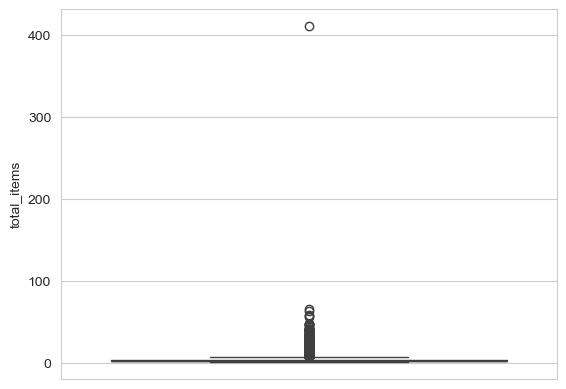

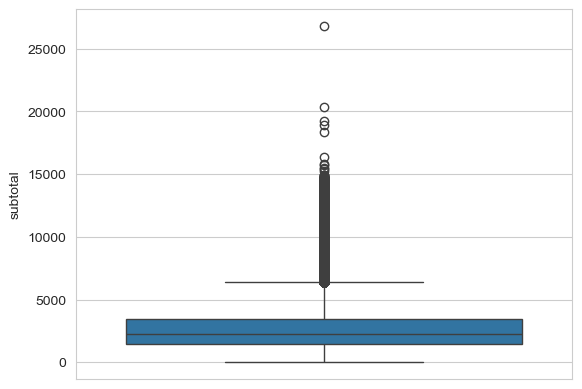

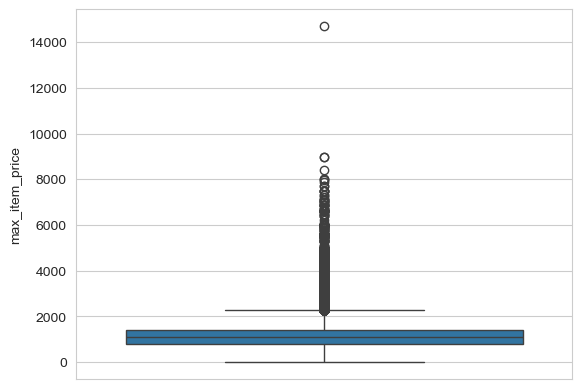

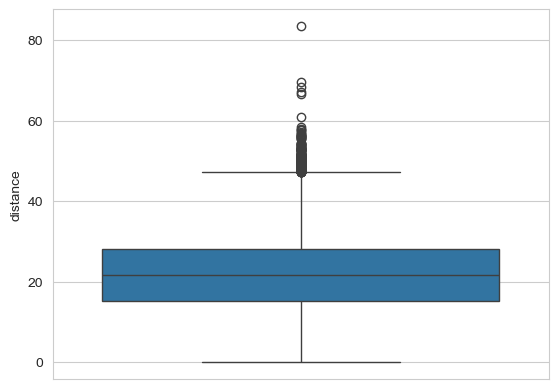

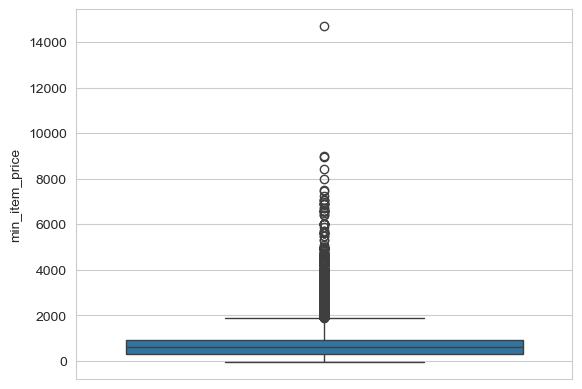

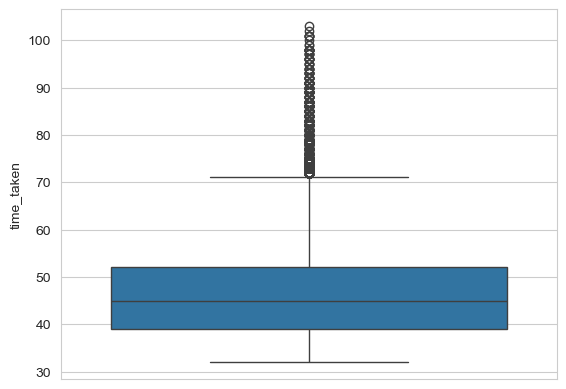

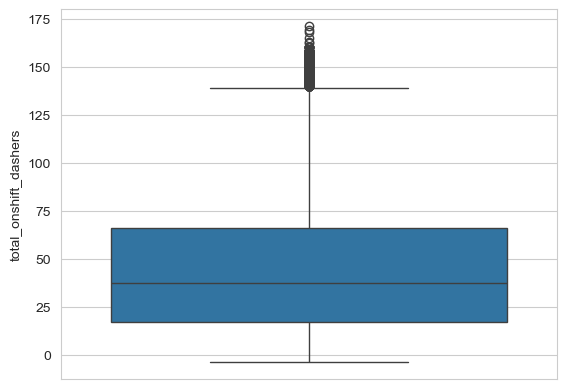

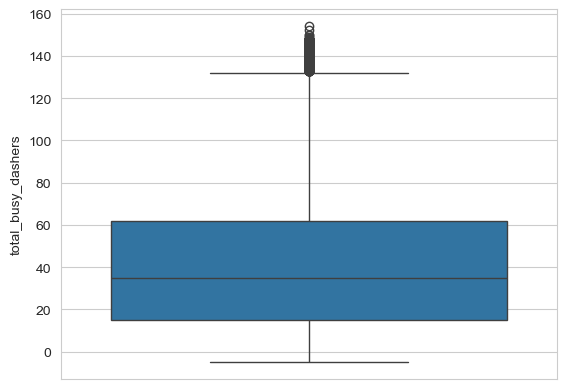

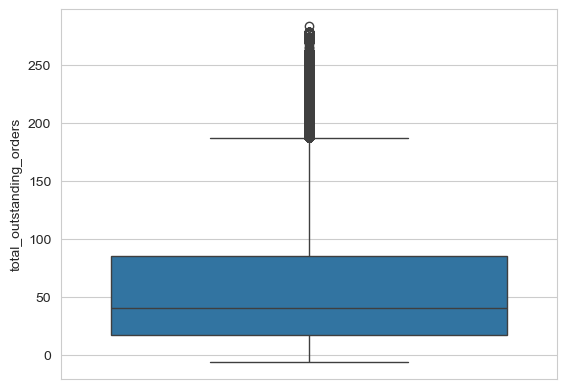

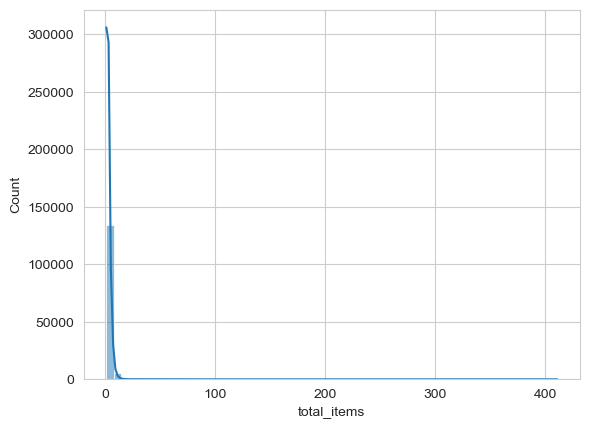

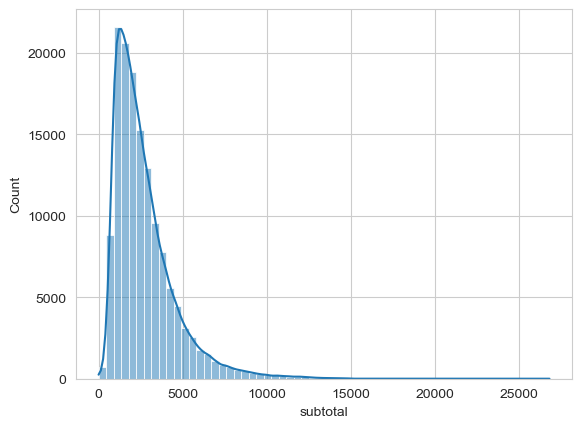

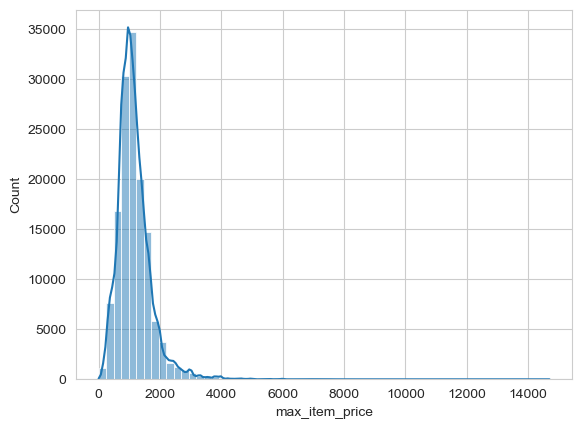

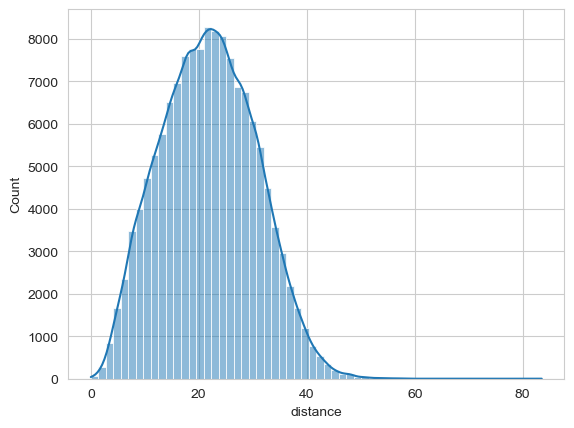

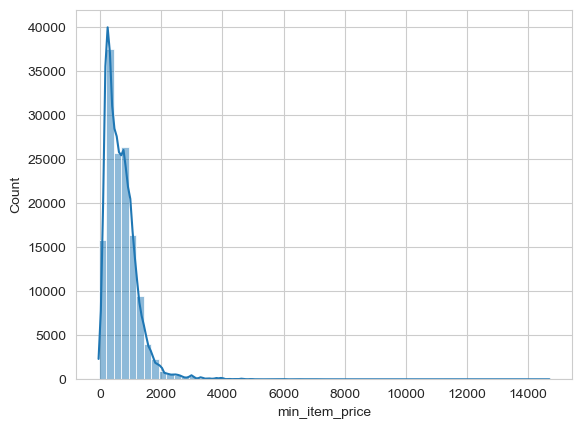

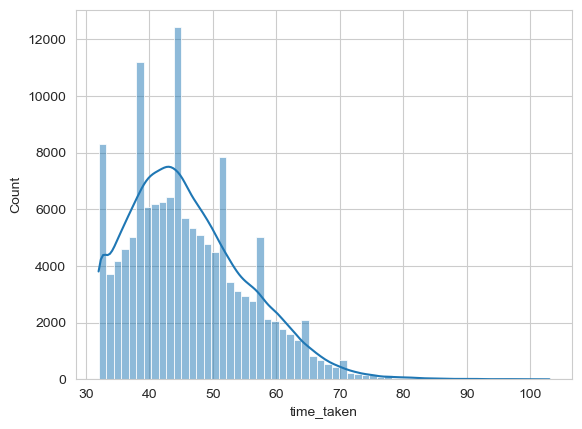

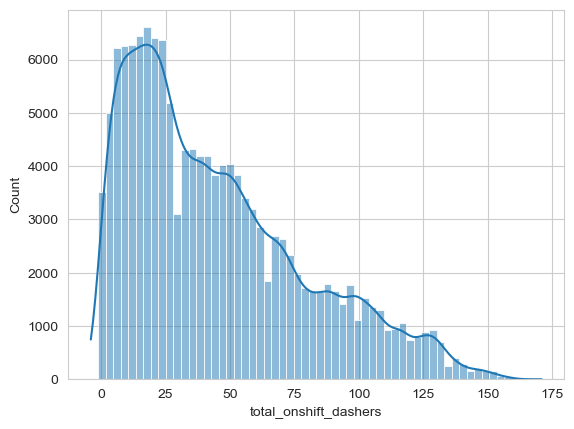

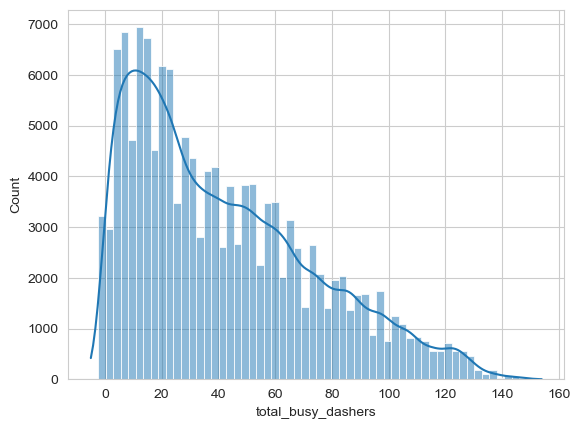

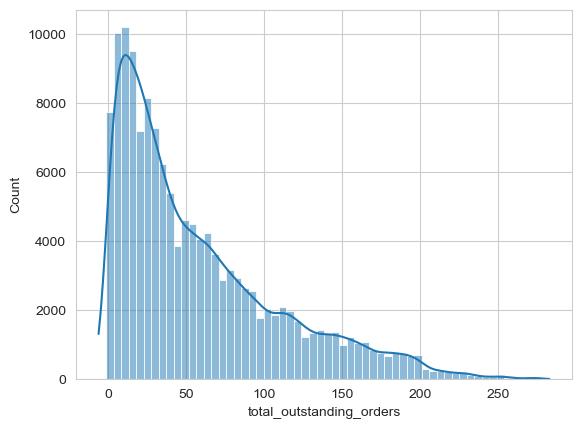

In [11]:
# Plot distributions for all numerical columns
for i in num_vars:
    sns.boxplot(df_train[i])
    plt.show()
for i in num_vars:
    sns.histplot(df_train[i], bins = 60, kde = True)
    plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

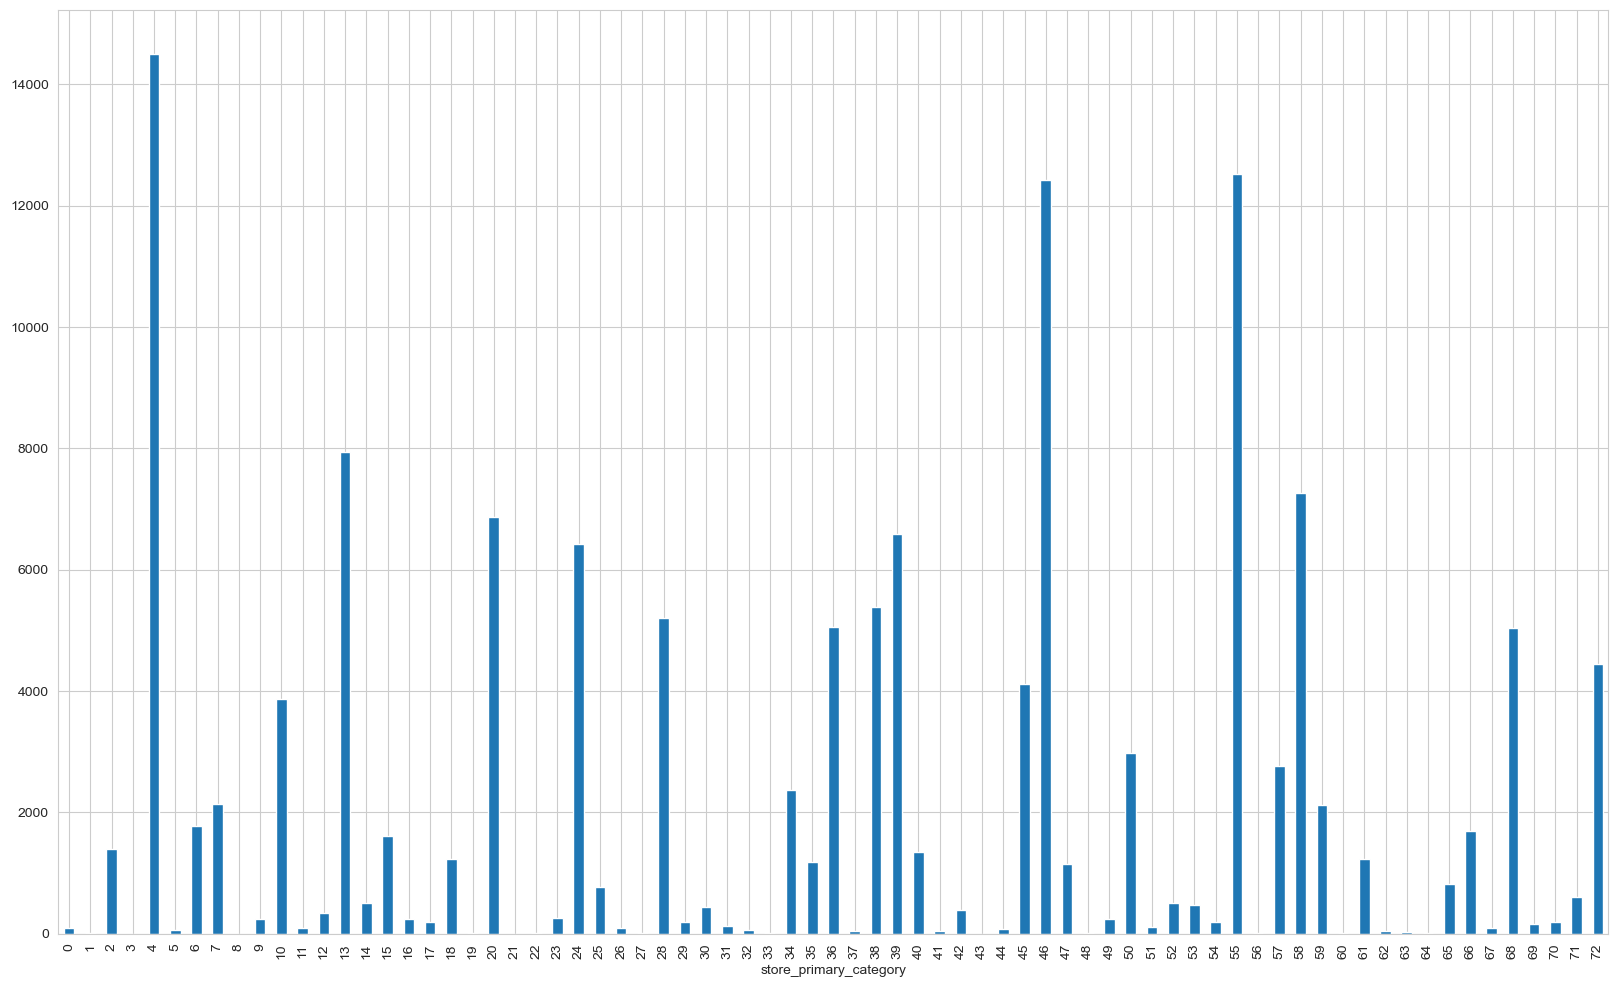

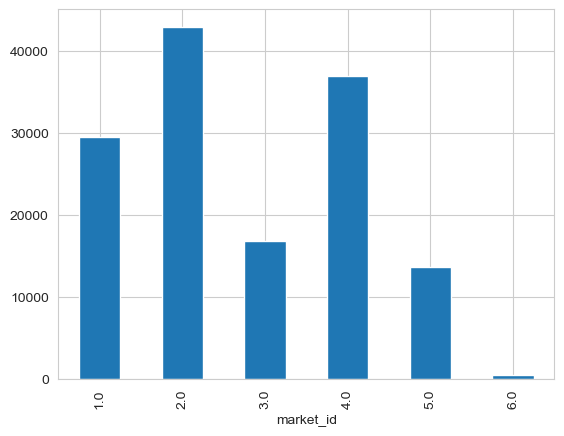

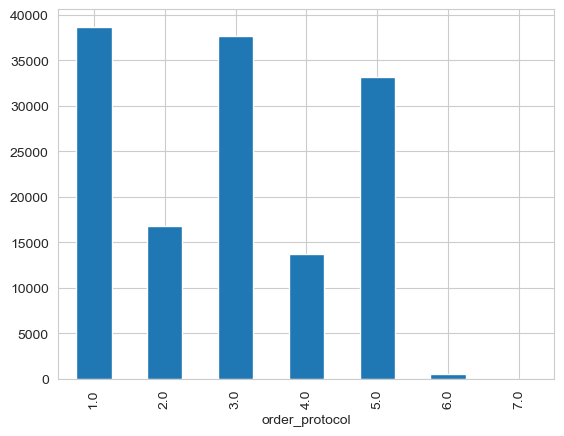

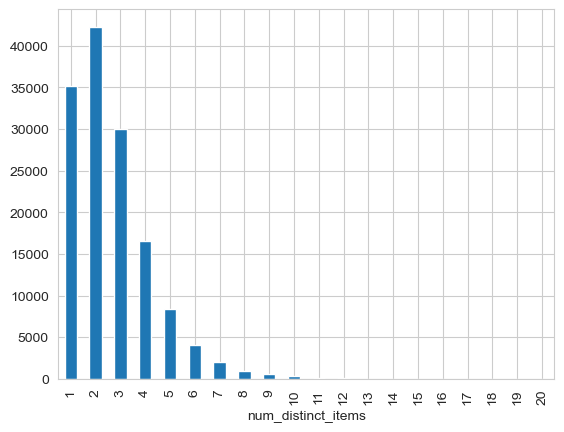

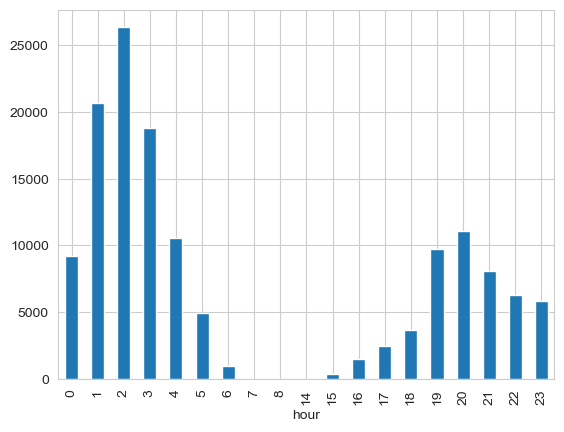

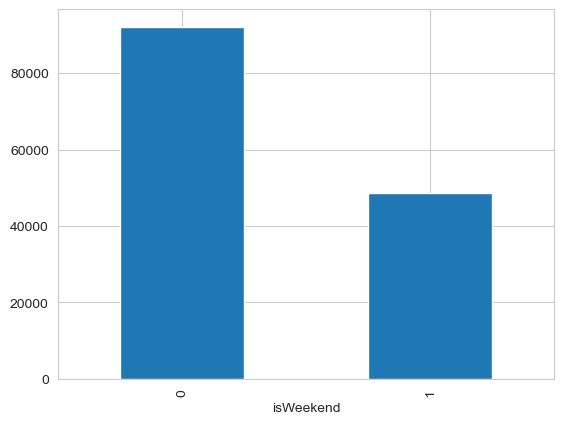

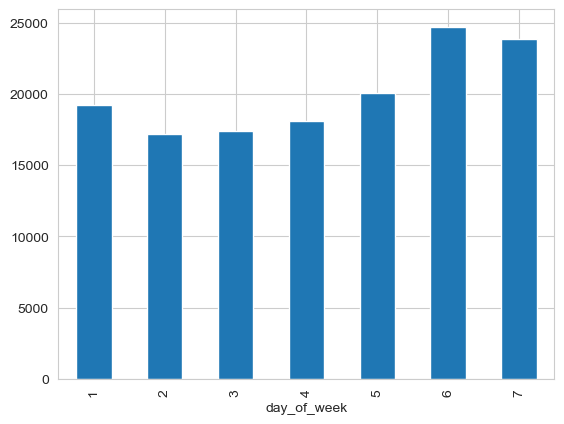

In [12]:
# Distribution of categorical columns
fig = plt.subplots(figsize = (20, 12))
for i in categoricals:
    df_train.groupby(i)[i].count().plot.bar()
    plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

count    140621.000000
mean         46.188044
std           9.323697
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         103.000000
Name: time_taken, dtype: float64


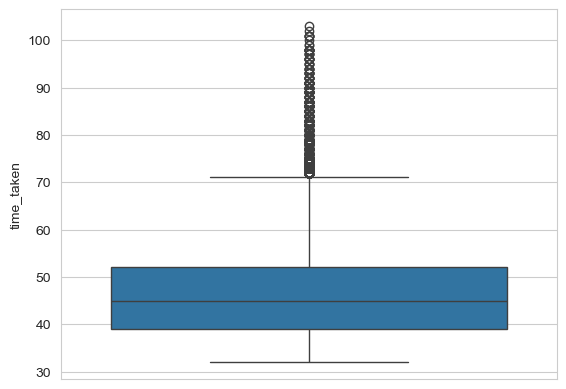

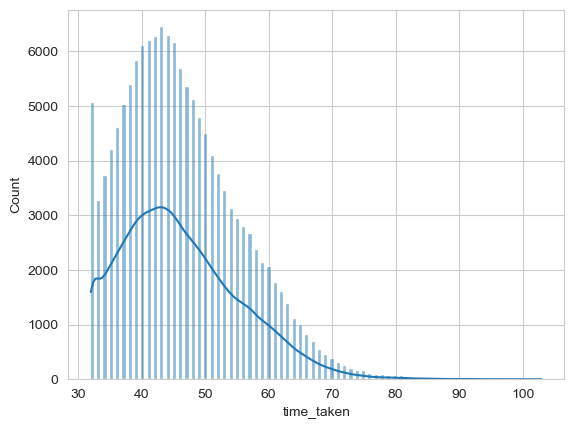

In [13]:
# Distribution of time_taken
print(df_train['time_taken'].describe())

sns.boxplot(df_train['time_taken'])
plt.show()
sns.histplot(df_train['time_taken'], kde = True)
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

['market_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour', 'isWeekend']
time_taken


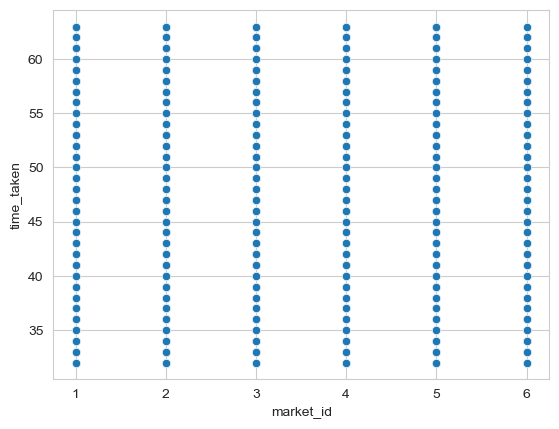

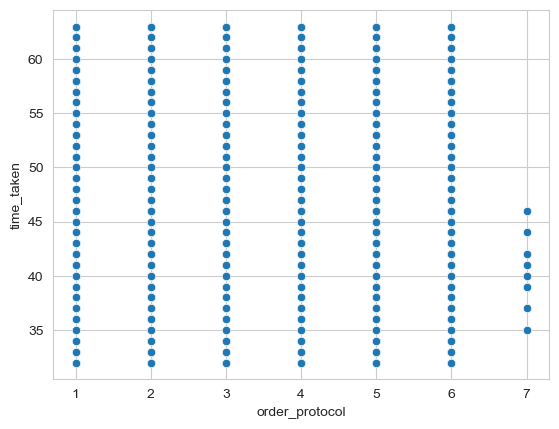

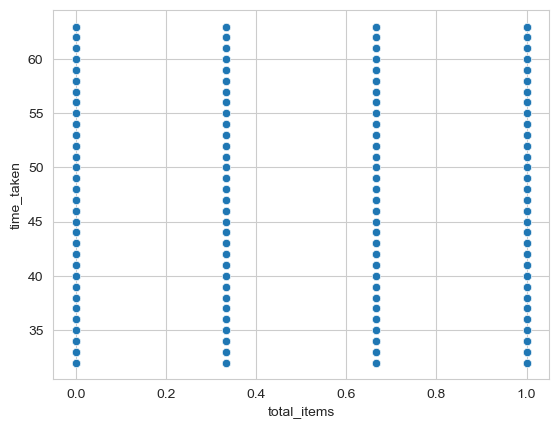

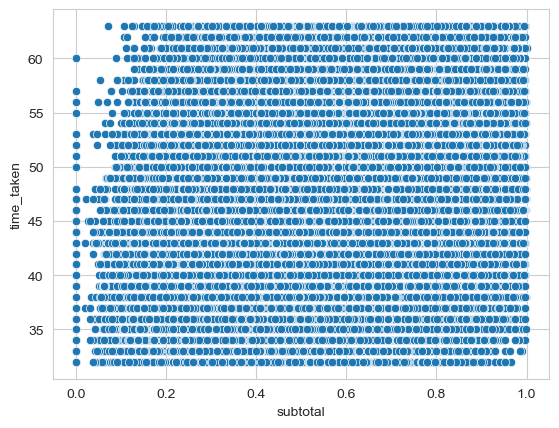

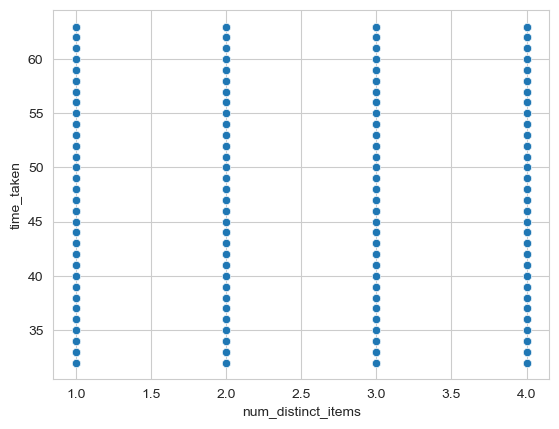

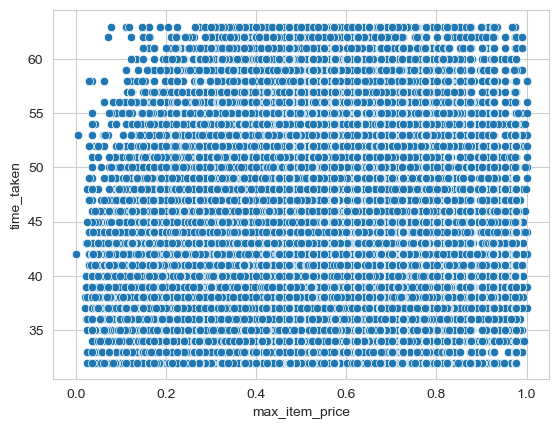

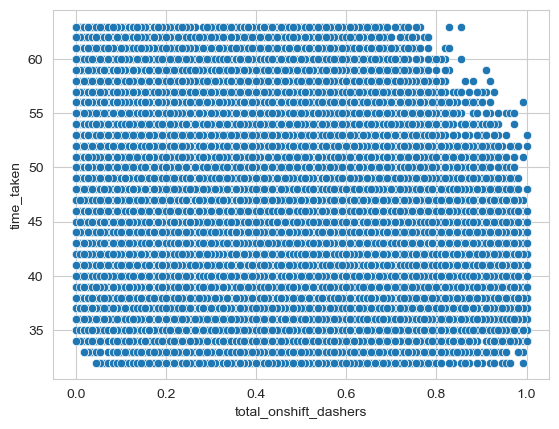

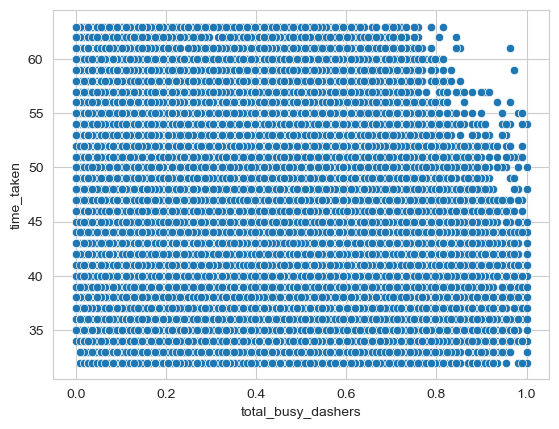

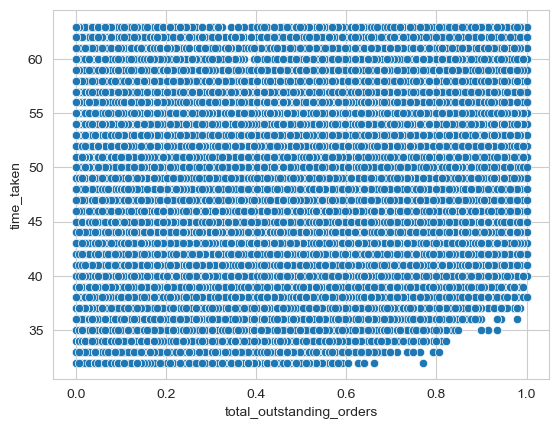

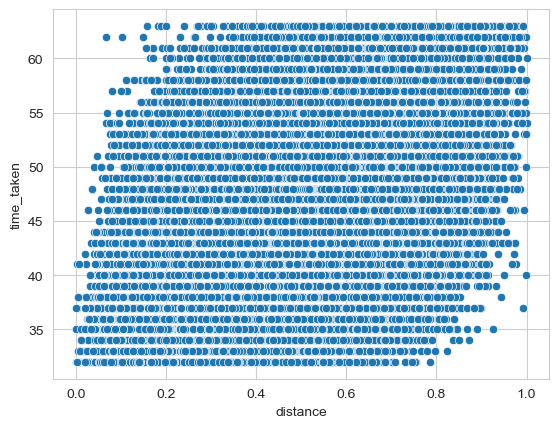

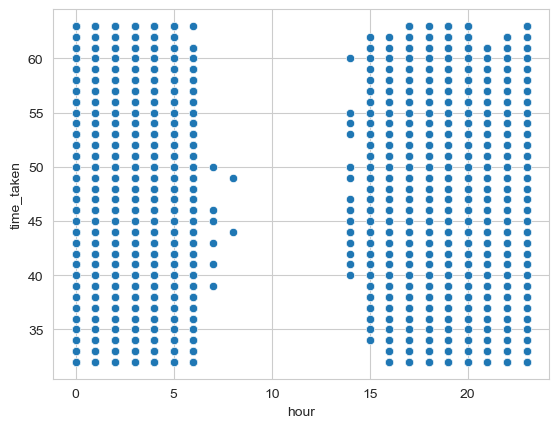

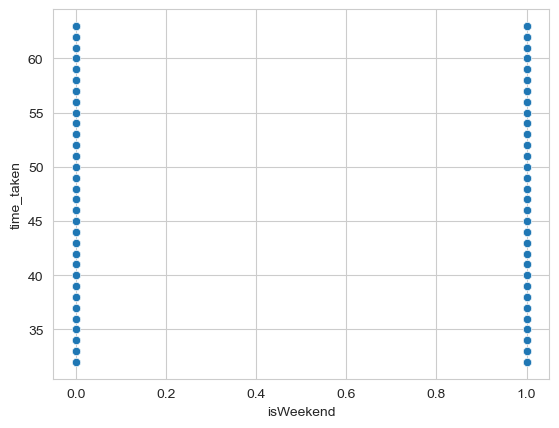

In [48]:
# Scatter plot to visualise the relationship between time_taken and other features
cols = list(df_train.columns)
cols.remove('time_taken')
y_axis = 'time_taken'
print(cols)
print(y_axis)
for i in cols:
    sns.scatterplot(data = df_train, x = df_train[i], y = df_train[y_axis])
    plt.show()
cols = ['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

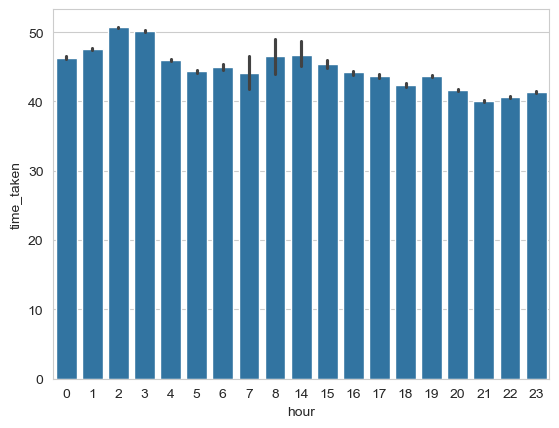

In [17]:
# Show the distribution of time_taken for different hours
sns.barplot(x = df_train['hour'], y = df_train['time_taken'])
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

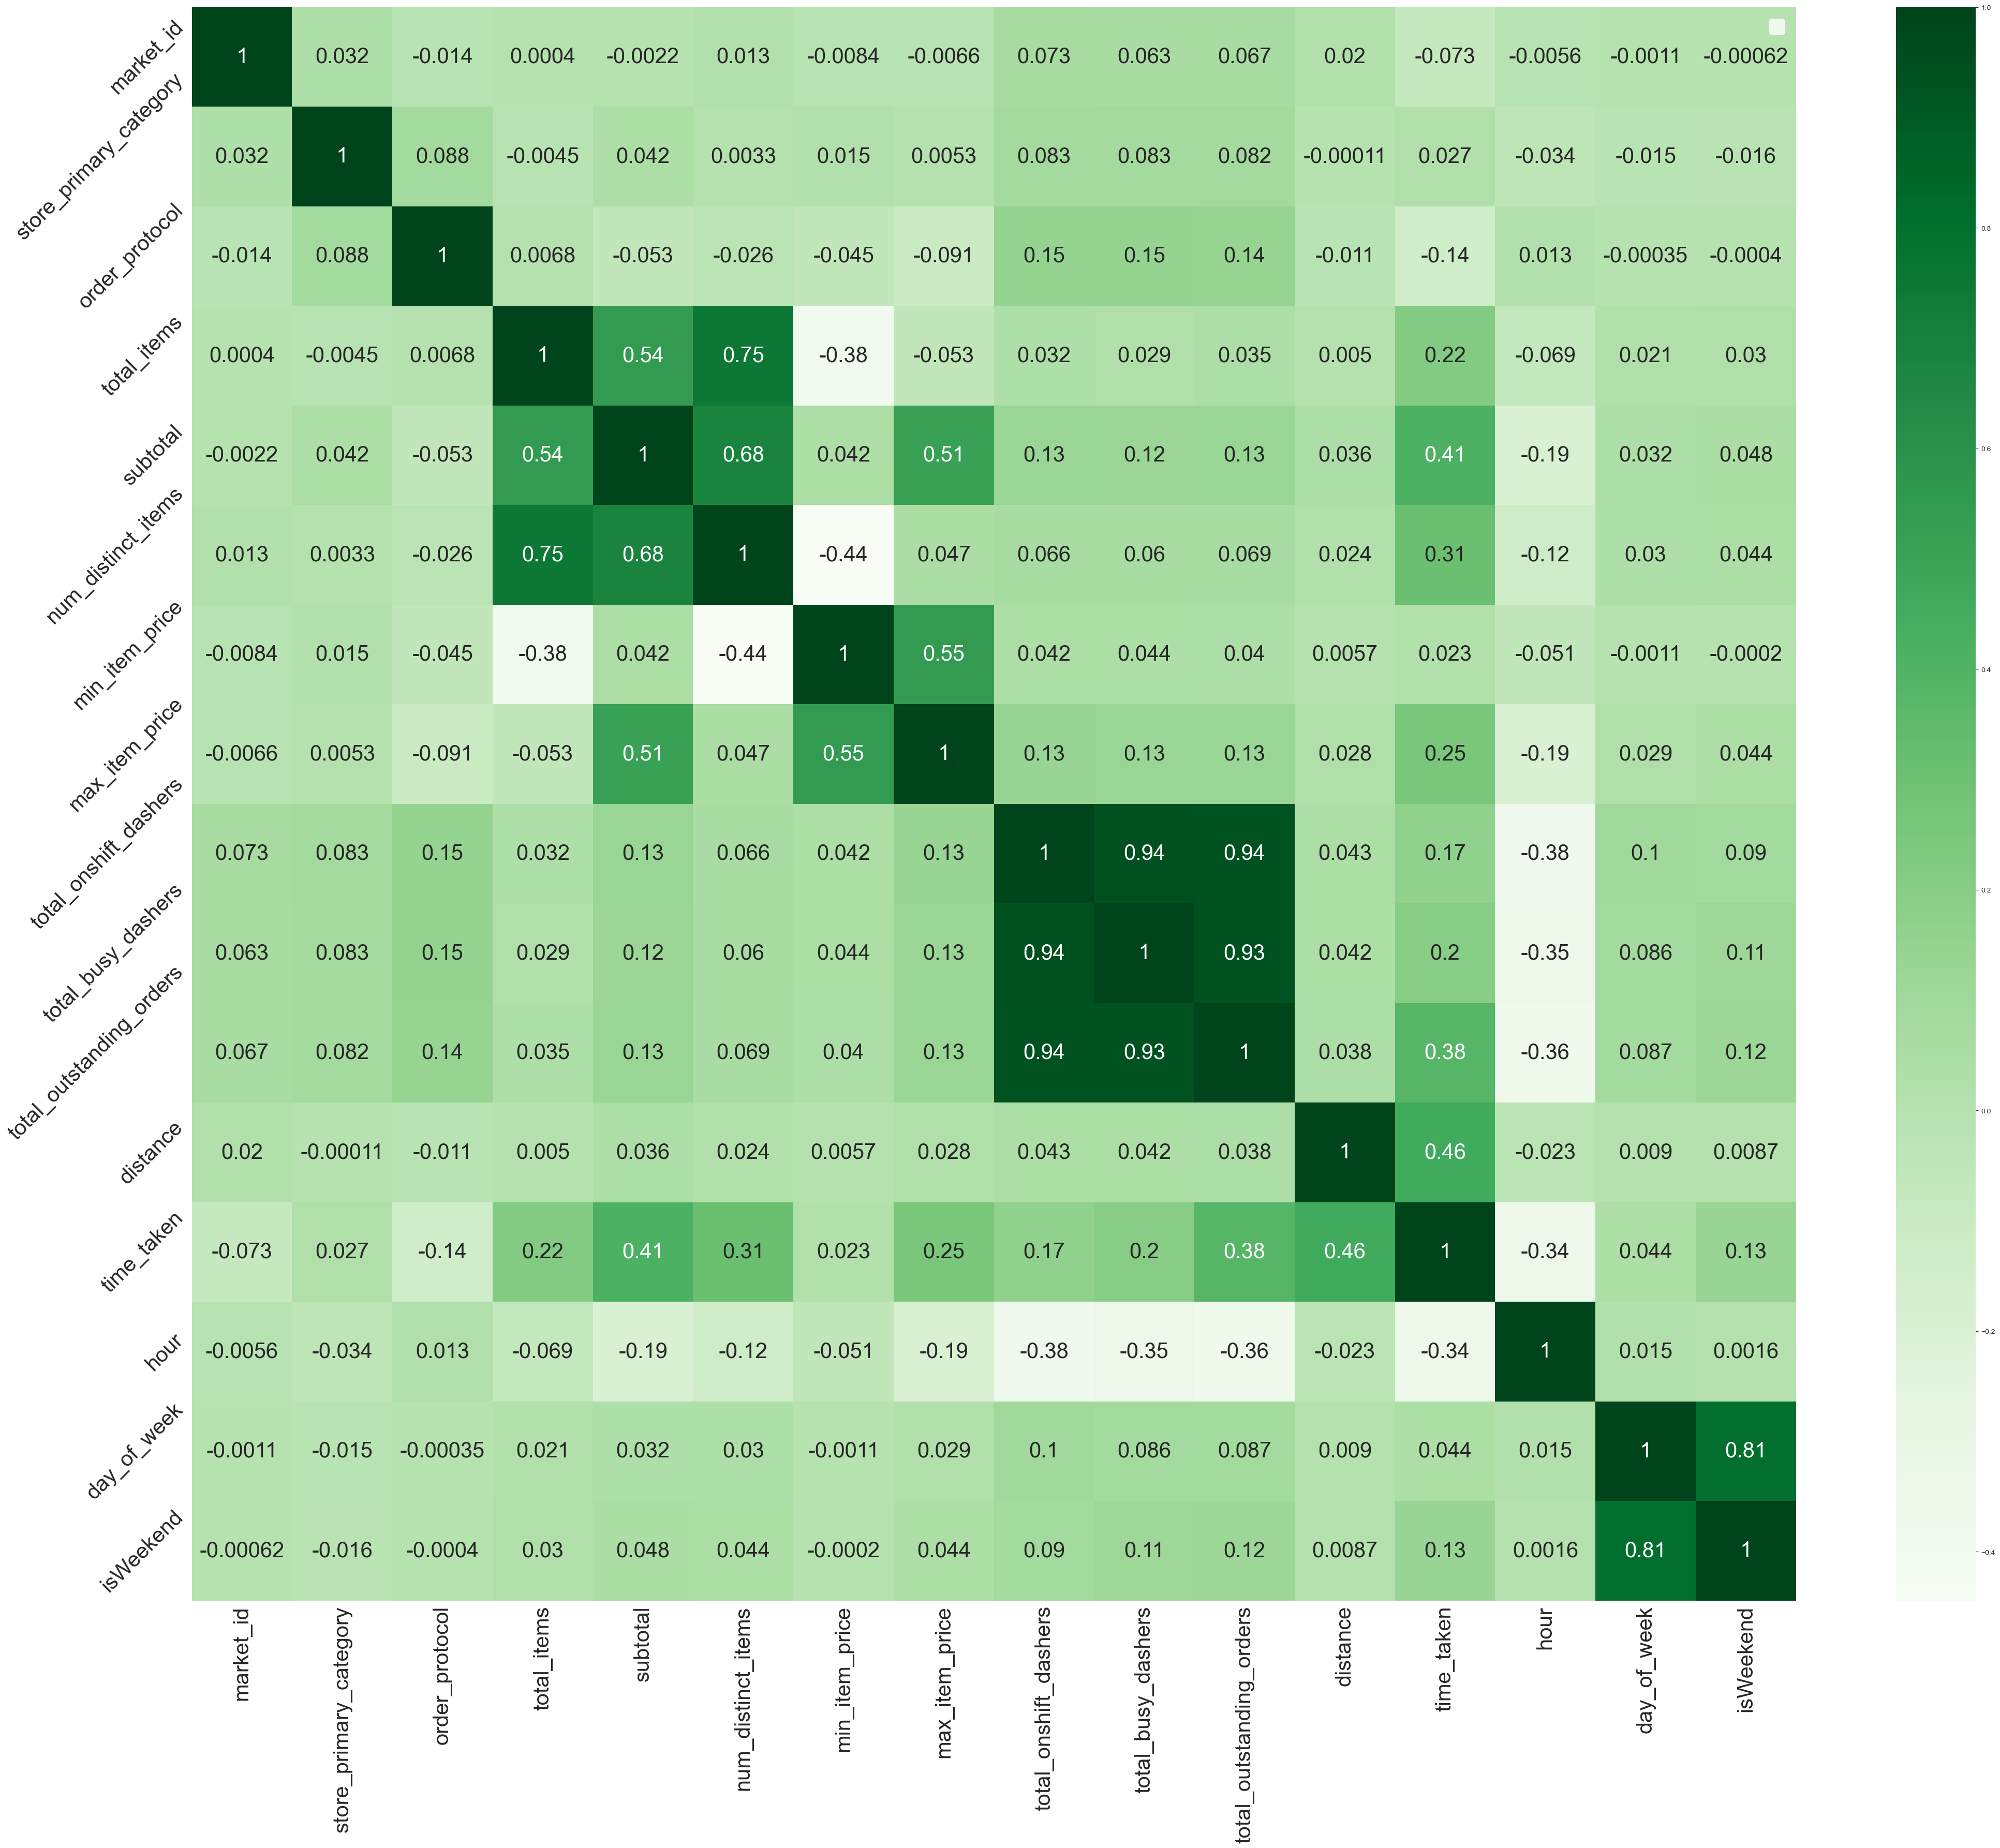

In [18]:
# Plot the heatmap of the correlation matrix
plt.subplots(figsize = (50, 40))
sns.heatmap(df_train.corr(), cmap = 'Greens', annot = True, annot_kws={'size': 30})
plt.xticks(fontsize= 30, rotation = 90)
plt.yticks(fontsize= 30, rotation = 45)
plt.legend(fontsize=30)
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [19]:
# Drop 3-5 weakly correlated columns from training dataset
df_train.drop(['min_item_price', 'day_of_week', 'store_primary_category'], inplace = True, axis = 1)
df_train

market_id order_protocol  total_items  subtotal num_distinct_items  \
42111        3.0            2.0            1      1350                  1   
58452        2.0            5.0            5      4285                  5   
20644        4.0            2.0            6      7880                  3   
79735        4.0            2.0            3      3660                  3   
167933       1.0            5.0            5      8575                  5   
...          ...            ...          ...       ...                ...   
82270        3.0            1.0            1       895                  1   
65615        2.0            5.0            7      3894                  6   
77655        2.0            5.0           17       448                  3   
56088        2.0            3.0            2      3000                  2   
38408        4.0            1.0            2      3750                  2   

        max_item_price  total_onshift_dashers  total_busy_dashers  \
42111             1350                   23.0                20.0   
58452              900                  112.0               100.0   
20644             1450                   80.0                79.0   
79735             1450                  127.0               106.0   
167933            2625                   44.0                44.0   
...                ...                    ...                 ...   
82270              895                    4.0                 2.0   
65615             1221                   64.0                60.0   
77655              289                   39.0                43.0   
56088             1500                   44.0                43.0   
38408             2050                   42.0                59.0   

        total_outstanding_orders  distance  time_taken  hour  isWeekend  
42111                       19.0      9.60        32.0    20          0  
58452                      207.0     34.56        71.0     2          1  
20644                      115.0     34.92        62.0     3          0  
79735                      173.0     25.76        54.0     2          1  
167933                      61.0     17.72        56.0     2          0  
...                          ...       ...         ...   ...        ...  
82270                        1.0     16.16        37.0    20          0  
65615                       64.0     22.64        36.0    23          1  
77655                       50.0     20.64        36.0     5          0  
56088                       63.0     21.64        44.0    19          0  
38408                       36.0     27.24        42.0     0          0  

[140621 rows x 13 columns]

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

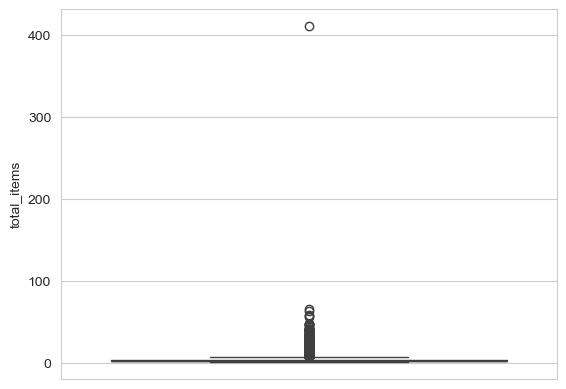

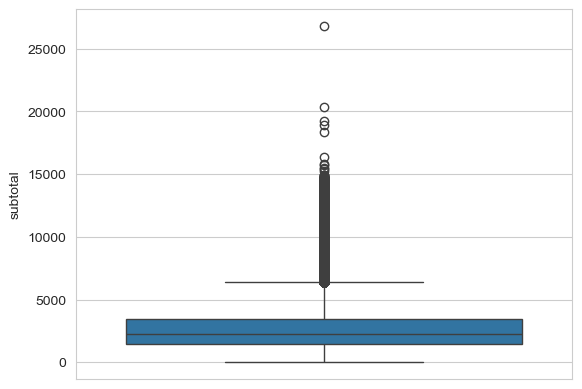

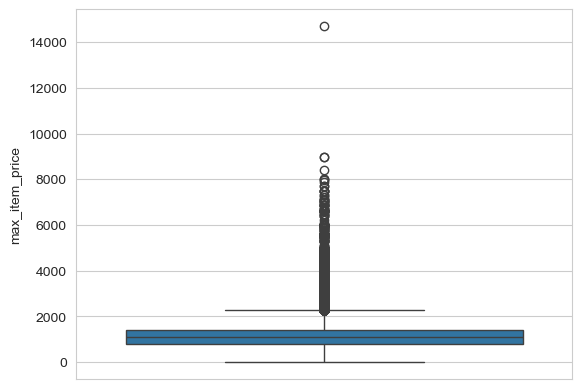

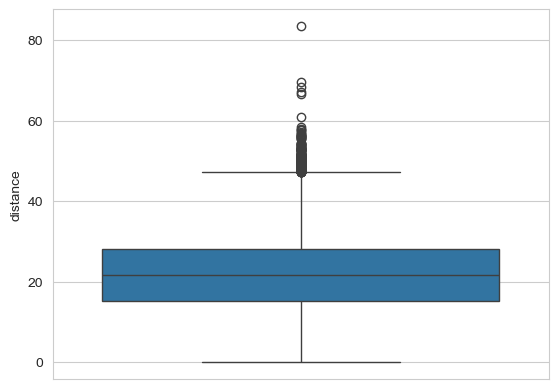

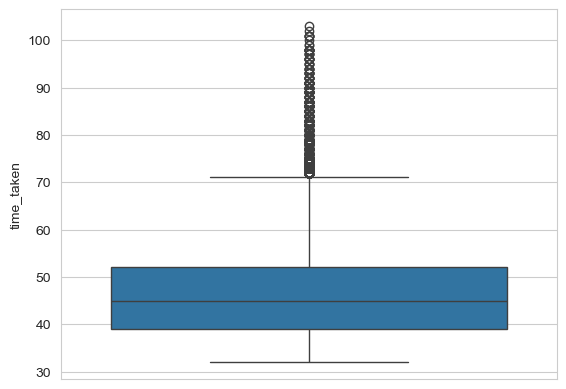

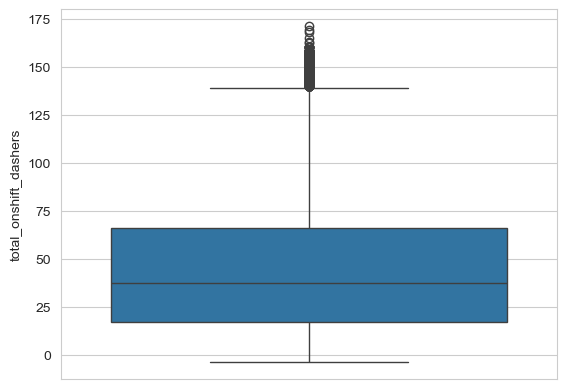

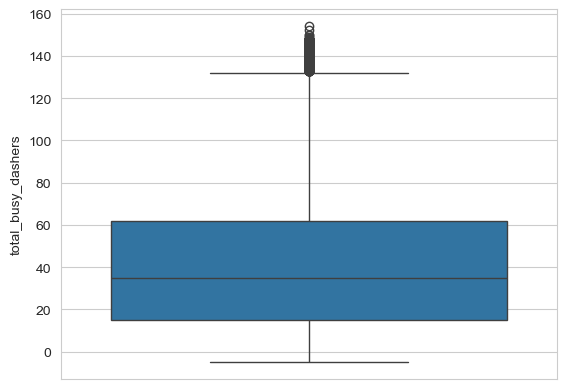

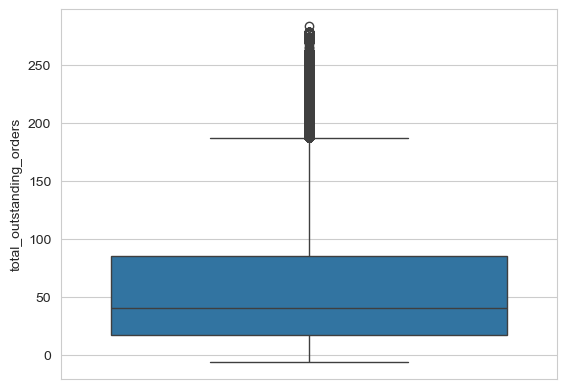

In [20]:
# Boxplot for time_taken
num_vars.remove('min_item_price')
for i in num_vars:
    sns.boxplot(df_train[i])
    plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [30]:
# Handle outliers

    
def outliers(out, x):
    q1 =np.percentile(out[x], 25)
    q3 = np.percentile(out[x], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(lower_bound, '  ', upper_bound)
    df_x = (out[x] < lower_bound) | (out[x] > upper_bound)
    print('outlier->', df_x.sum())
    out = out[~df_x]
    return out    
cols1 = list(df_train.columns)


df_copy = df_train.copy()
for i in num_vars:
    df_copy = outliers(df_copy, i)
df_train = df_copy.copy()
print(df_train.describe())
def dropZeroNegative(out, x):
    df_x = out[x] < 0
    out = out[~df_x]
    return out
for i in num_vars:
    df_copy = dropZeroNegative(df_copy, i)

    
print(df_copy.describe())
df_train = df_copy.copy()
# categoricals.remove('store_primary_category')
# categoricals.remove('day_of_week')
print('Categorical Variables', categoricals)
for i in categoricals:
    print(df_train[i].describe())


-2.0    6.0
outlier-> 0
-820.0    4620.0
outlier-> 0
45.0    2045.0
outlier-> 0
-3.9200000000000017    46.64
outlier-> 0
23.0    63.0
outlier-> 0
-42.0    110.0
outlier-> 0
-44.0    108.0
outlier-> 0
-61.0    139.0
outlier-> 0
        total_items      subtotal  max_item_price  total_onshift_dashers  \
count  91628.000000  91628.000000    91628.000000           91628.000000   
mean       2.265225   1970.690160     1042.962697              35.628509   
std        0.995260    936.445578      367.695282              25.640696   
min        1.000000      0.000000       52.000000               0.000000   
25%        1.000000   1220.000000      795.000000              15.000000   
50%        2.000000   1798.000000      999.000000              30.000000   
75%        3.000000   2580.000000     1295.000000              53.000000   
max        4.000000   4620.000000     2045.000000             110.000000   

       total_busy_dashers  total_outstanding_orders      distance  \
count        91628.

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [31]:
# Define numerical and categorical columns for easy EDA and data manipulation
def outliers(out, x):
    q1 =np.percentile(out[x], 25)
    q3 = np.percentile(out[x], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(lower_bound, '  ', upper_bound)
    df_x = (out[x] < lower_bound) | (out[x] > upper_bound)
    print('outlier->', df_x.sum())
    out = out[~df_x]
    return out    
cols1 = list(df_test.columns)

cols1.remove('time_taken')
df_copy_test = df_test.copy()
for i in num_vars:
    df_copy_test = outliers(df_copy_test, i)
df_test = df_copy_test.copy()
print(df_test.describe())
def dropZeroNegative(out, x):
    df_x = out[x] < 0
    out = out[~df_x]
    return out
for i in num_vars:
    df_copy_test = dropZeroNegative(df_copy_test, i)
print(df_copy_test.describe())
df_test = df_copy_test.copy()


-1.0    7.0
outlier-> 1729
-1395.75    6046.25
outlier-> 1113
-65.0    2239.0
outlier-> 1061
-3.92    47.28
outlier-> 45
21.0    69.0
outlier-> 309
-53.5    134.5
outlier-> 308
-52.5    127.5
outlier-> 168
-77.5    174.5
outlier-> 1044
        total_items      subtotal  min_item_price  max_item_price  \
count  29379.000000  29379.000000    29379.000000    29379.000000   
mean       2.730318   2280.302937      665.214303     1071.559720   
std        1.473901   1206.160430      427.094573      396.062091   
min        1.000000      0.000000      -86.000000        0.000000   
25%        2.000000   1326.500000      300.000000      795.000000   
50%        2.000000   2019.000000      599.000000     1025.000000   
75%        4.000000   2998.000000      942.000000     1300.000000   
max        7.000000   6045.000000     2229.000000     2235.000000   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
count           29379.000000        29379.000000              29

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

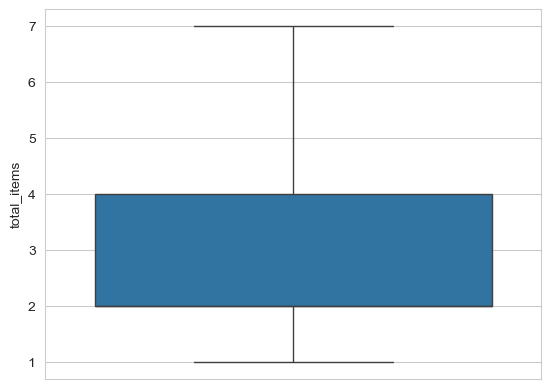

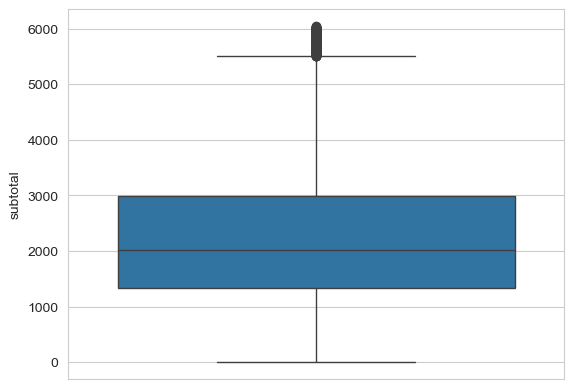

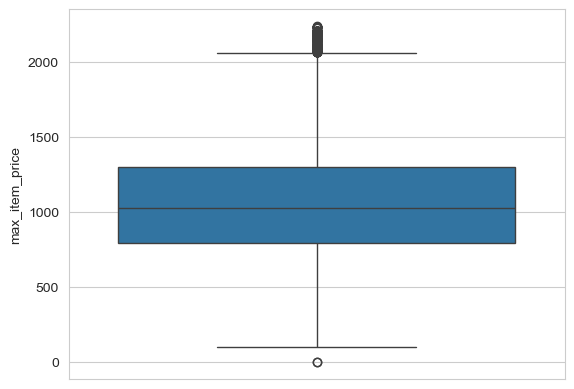

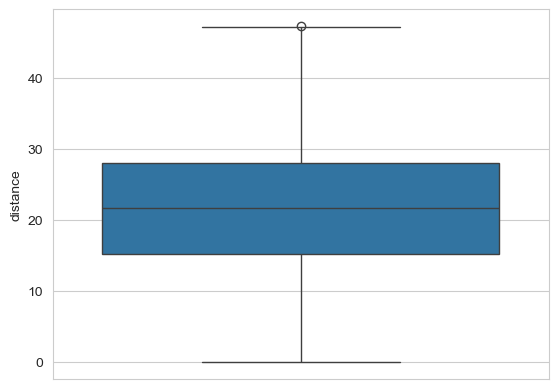

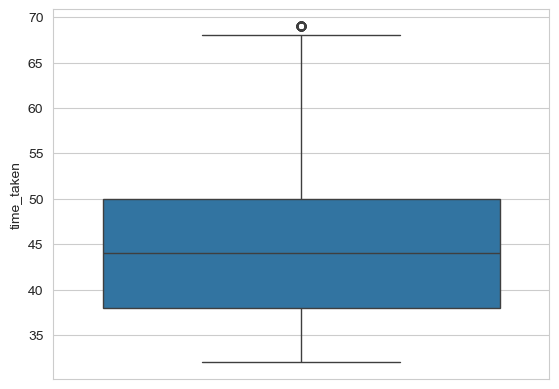

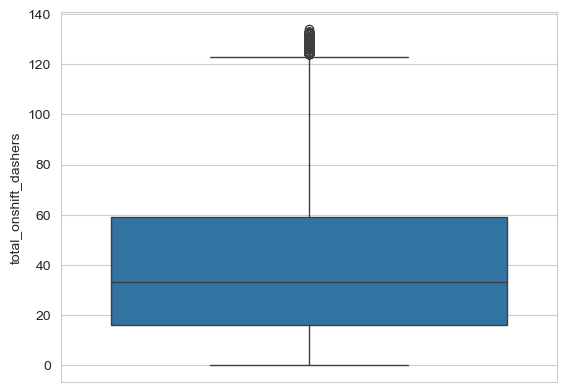

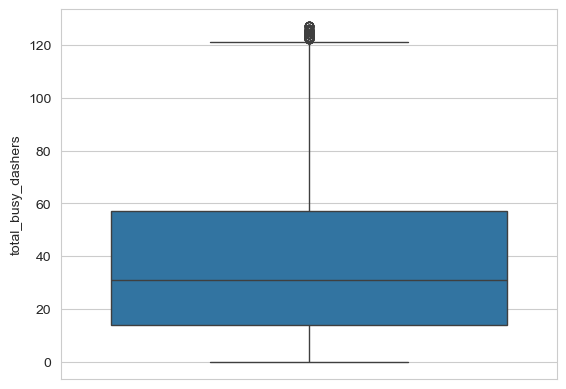

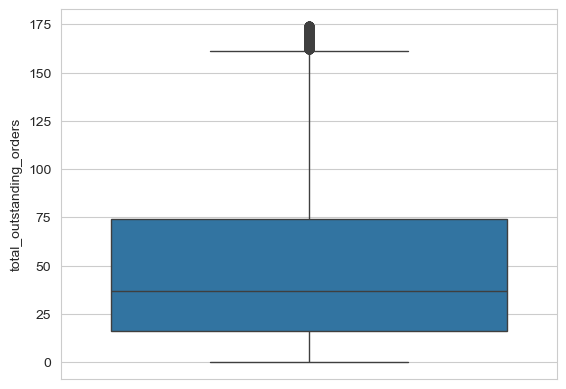

In [32]:
# Plot distributions for all numerical columns
df_test.describe()
for i in num_vars:
    sns.boxplot(df_test[i])
    plt.show()

##### **4.1.2**
Check the distribution of categorical features

['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour', 'day_of_week', 'isWeekend']


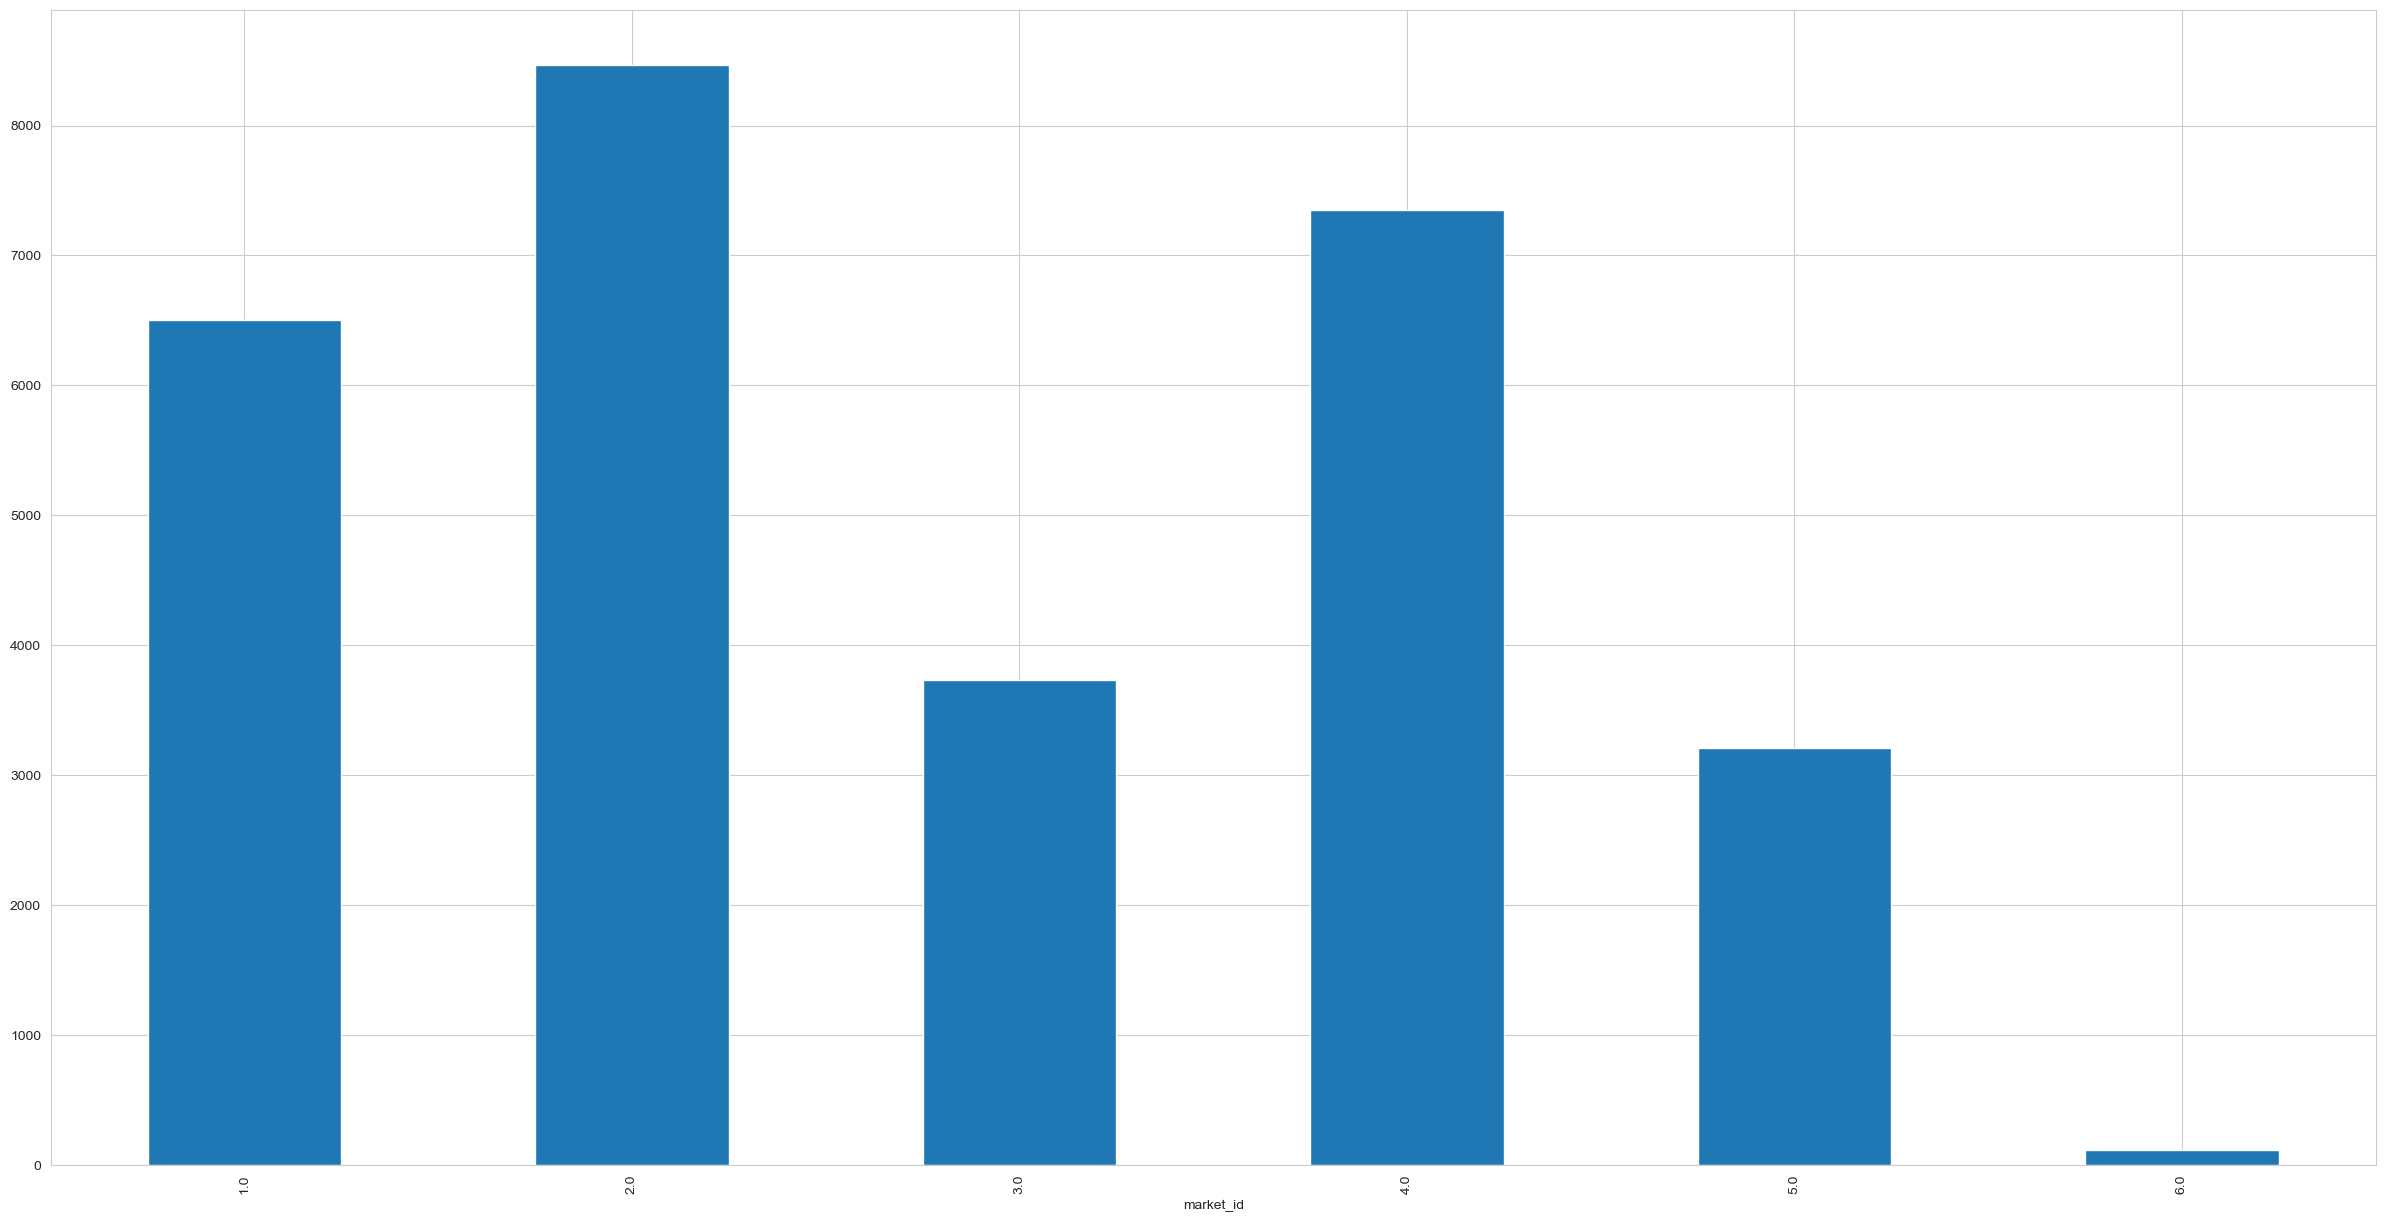

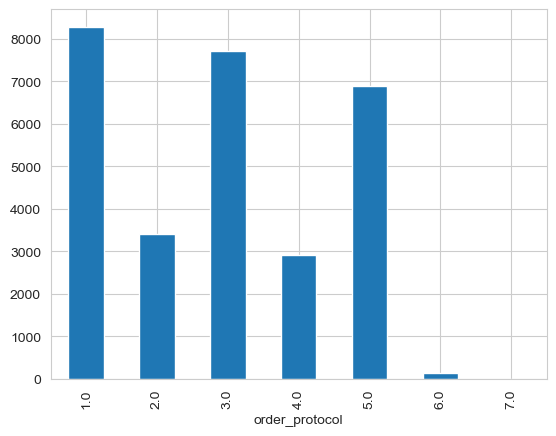

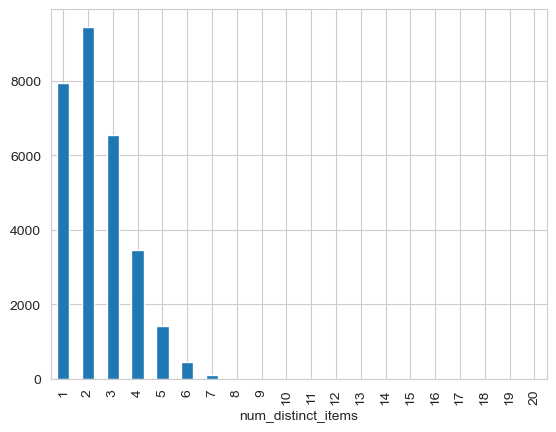

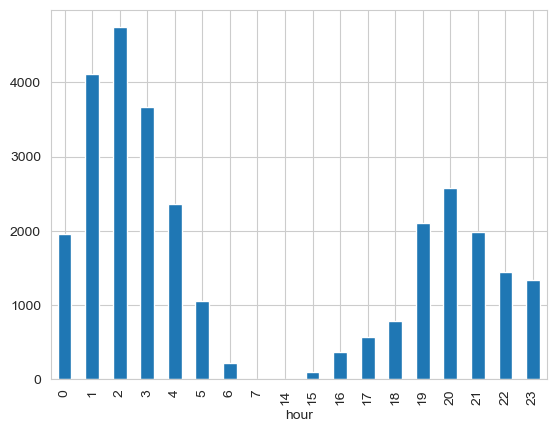

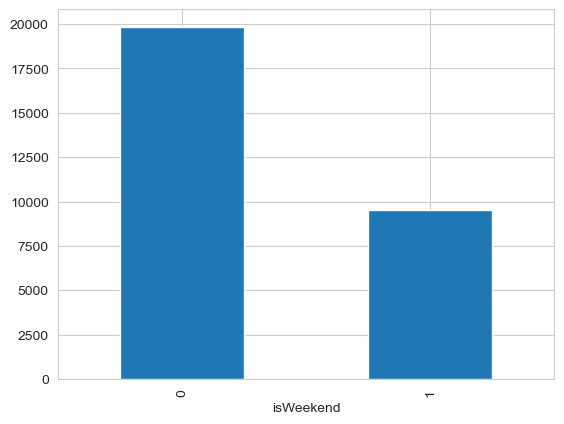

In [33]:
# Distribution of categorical columns
# for i in cols1:
#     sns.boxplot(df_test[i])
#     plt.show()
print(cols)
print(cols1)
fig = plt.subplots(figsize = (30, 15))
a = ['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
# for i in a:
#     
#     cols1.remove(i)
for i in categoricals:
    df_test.groupby(i)[i].count().plot.bar()
    plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

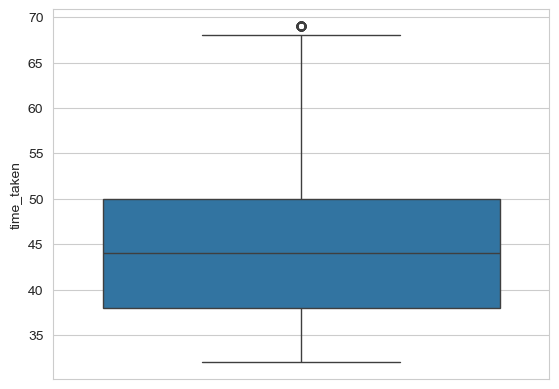

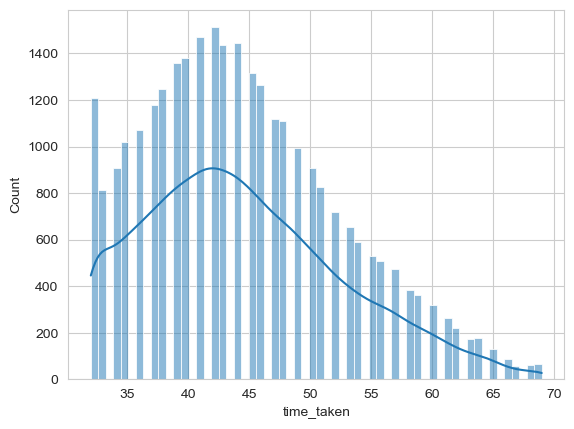

In [34]:
# Distribution of time_taken
sns.boxplot(df_test['time_taken'])
plt.show()
sns.histplot(df_test['time_taken'], bins = 60, kde = True)
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

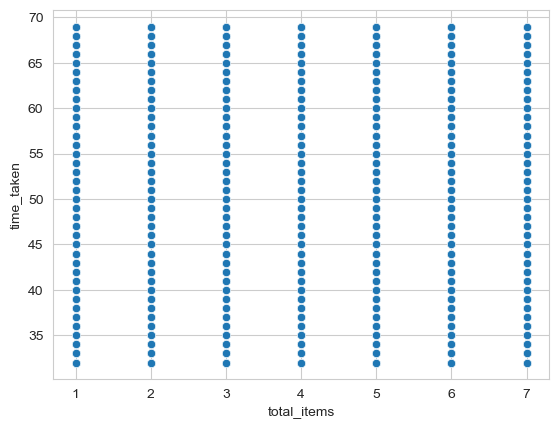

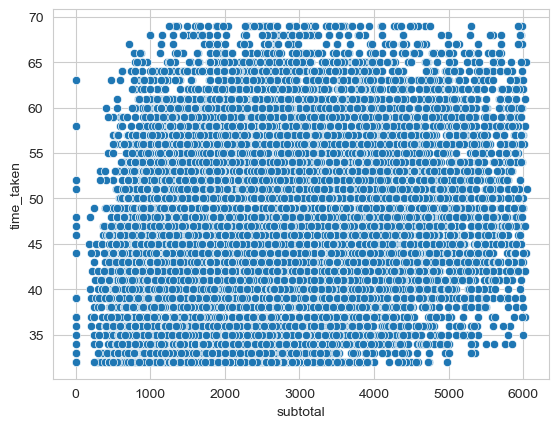

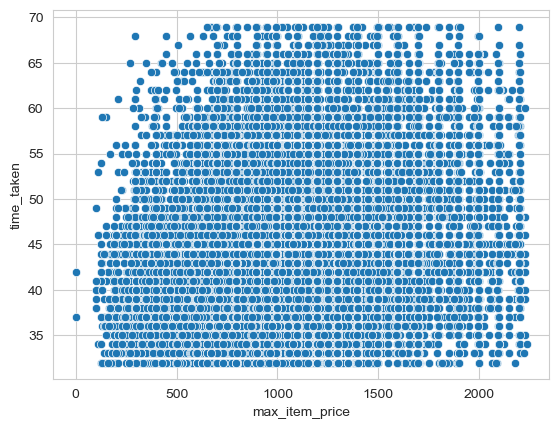

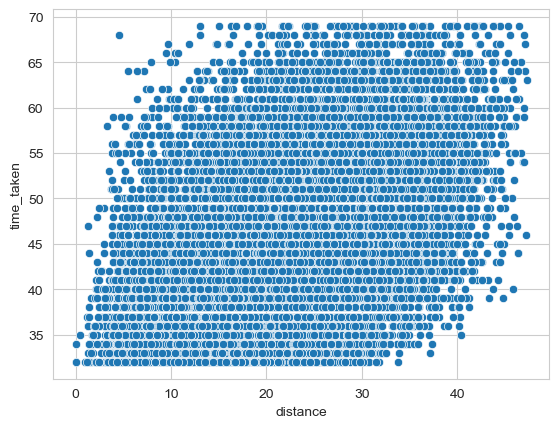

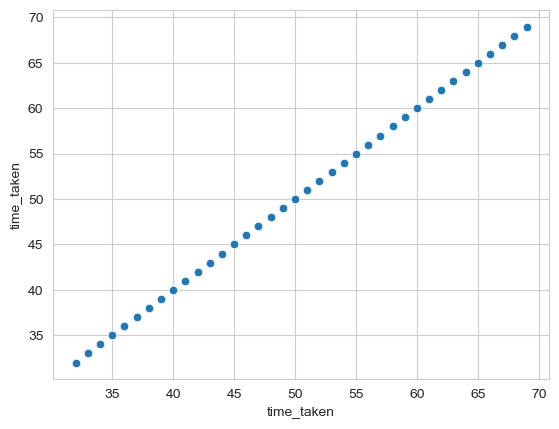

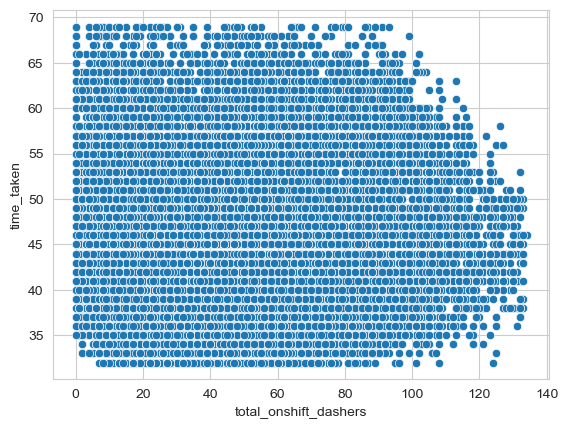

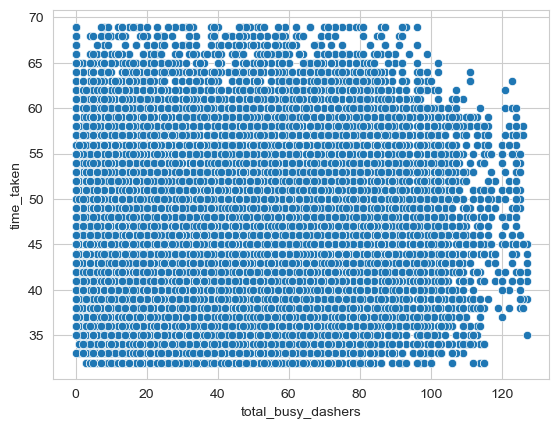

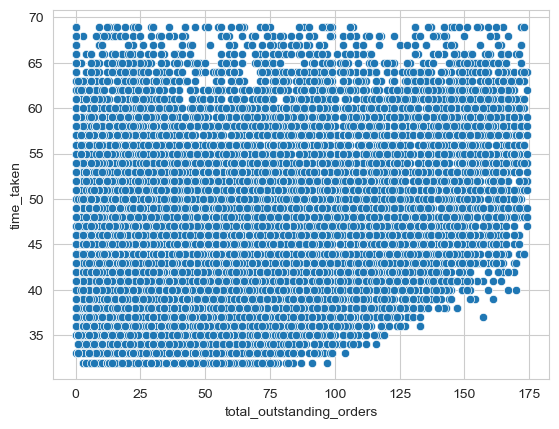

In [35]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in num_vars:
    sns.scatterplot(x = df_test[col], y = df_test['time_taken'])
    plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

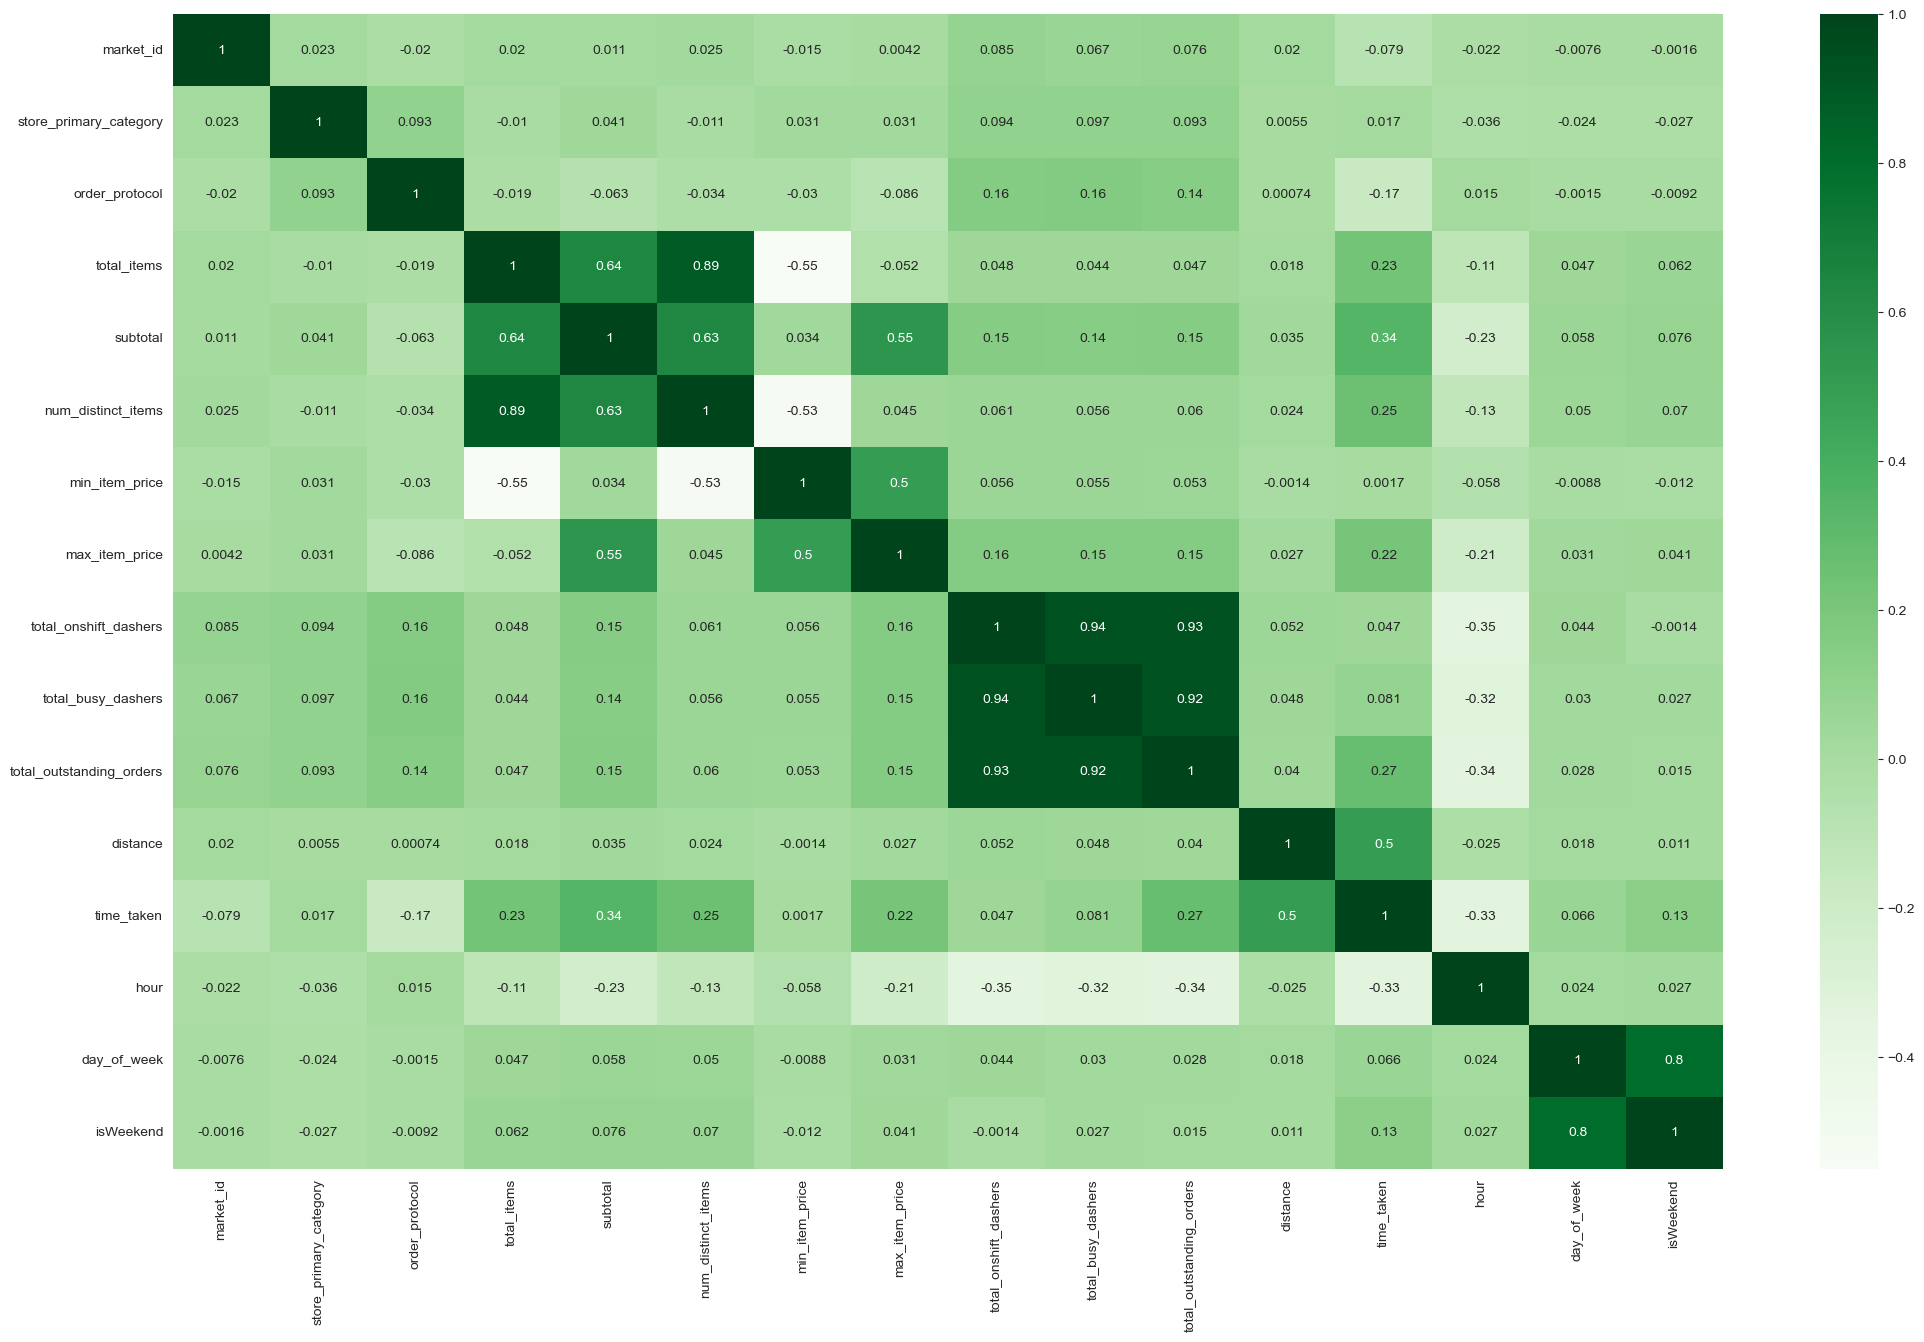

In [36]:
# Drop the weakly correlated columns from training dataset
df_train.describe()
fig = plt.subplots(figsize = (25, 15))

sns.heatmap(df_test.corr(), cmap = 'Greens', annot = True)

plt.show()

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [37]:
# Import libraries
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [38]:
# Apply scaling to the numerical columns
scaler = MinMaxScaler()

print(cols)

df_train[cols] = scaler.fit_transform(df_train[cols])

['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [39]:
# Create/Initialise the model
X_train = df_train.copy()
y_train = X_train.pop('time_taken')
X_train_lm = sm.add_constant(X_train)

In [40]:
# Train the model using the training data
lr = sm.OLS(y_train, X_train_lm).fit()
print('LR1->', lr.summary())
print('LR1->', lr.params)
l = list([])
vif = pd.DataFrame()
vif['features'] = X_train_lm.columns
for i in range(X_train_lm.shape[1]):
    l.append(variance_inflation_factor(X_train_lm.values, i))
vif['vif'] = l   
vif['vif'] = round(vif['vif'], 2)
vif = vif.sort_values(by = 'vif', ascending= False)
print('VIF for 1->', vif)

X_train.drop('total_busy_dashers', axis = 1, inplace = True)
X_train_lm.drop('total_busy_dashers', axis = 1, inplace = True)
lr2 = sm.OLS(y_train, X_train_lm).fit()
print('LR2->', lr2.summary())
print('LR2->', lr2.params)
l = list([])
vif = pd.DataFrame()
vif['features'] = X_train_lm.columns
for i in range(X_train_lm.shape[1]):
    l.append(variance_inflation_factor(X_train_lm.values, i))
vif['vif'] = l   
vif['vif'] = round(vif['vif'], 2)
vif = vif.sort_values(by = 'vif', ascending= False)
print('VIF for 2->', vif)




LR1->                             OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 4.618e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        11:15:08   Log-Likelihood:            -2.2173e+05
No. Observations:               91628   AIC:                         4.435e+05
Df Residuals:                   91615   BIC:                         4.436e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const             

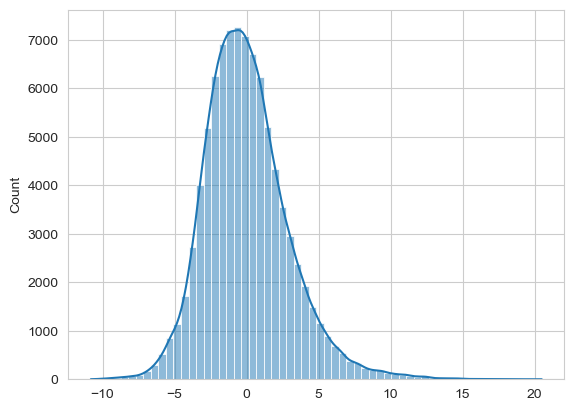

r2_score =  0.838208373154112
mse =  8.442308112077763
y_train 42111     32.0
80691     44.0
170910    45.0
64999     48.0
153278    46.0
          ... 
144962    45.0
20533     39.0
145332    45.0
82270     37.0
56088     44.0
Name: time_taken, Length: 91628, dtype: float64
y_train_pred 42111     32.541358
80691     43.748828
170910    41.112059
64999     48.513529
153278    45.469574
            ...    
144962    45.184468
20533     39.284698
145332    45.134563
82270     38.375132
56088     45.388266
Length: 91628, dtype: float64


In [41]:
# Make predictions
y_train_pred = lr2.predict(X_train_lm)
sns.histplot(y_train - y_train_pred, bins = 60, kde = True)
plt.show()
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_train, y_train_pred)
print('r2_score = ', r2)
mse = mean_squared_error(y_train, y_train_pred)
print('mse = ', mse)
print('y_train', y_train)
print('y_train_pred', y_train_pred)



# plt.plot(X_train_lm,y , 'r')
# plt.show()

        total_items  subtotal  max_item_price  total_onshift_dashers  \
139667     0.666667  0.280303        0.473156               0.536364   
80077      0.333333  0.638528        0.588560               0.163636   
41872      0.000000  0.301948        0.673859               0.254545   
151215     0.666667  0.270563        0.174611               0.354545   
31509      0.666667  0.280736        0.224285               0.127273   

        total_busy_dashers  total_outstanding_orders  distance  
139667            0.546296                  0.438849  0.440823  
80077             0.157407                  0.115108  0.275300  
41872             0.250000                  0.323741  0.360206  
151215            0.277778                  0.237410  0.572899  
31509             0.120370                  0.079137  0.209262  
        total_items      subtotal  min_item_price  max_item_price  \
count  29371.000000  29371.000000    29371.000000    29371.000000   
mean       0.576714      0.493577      

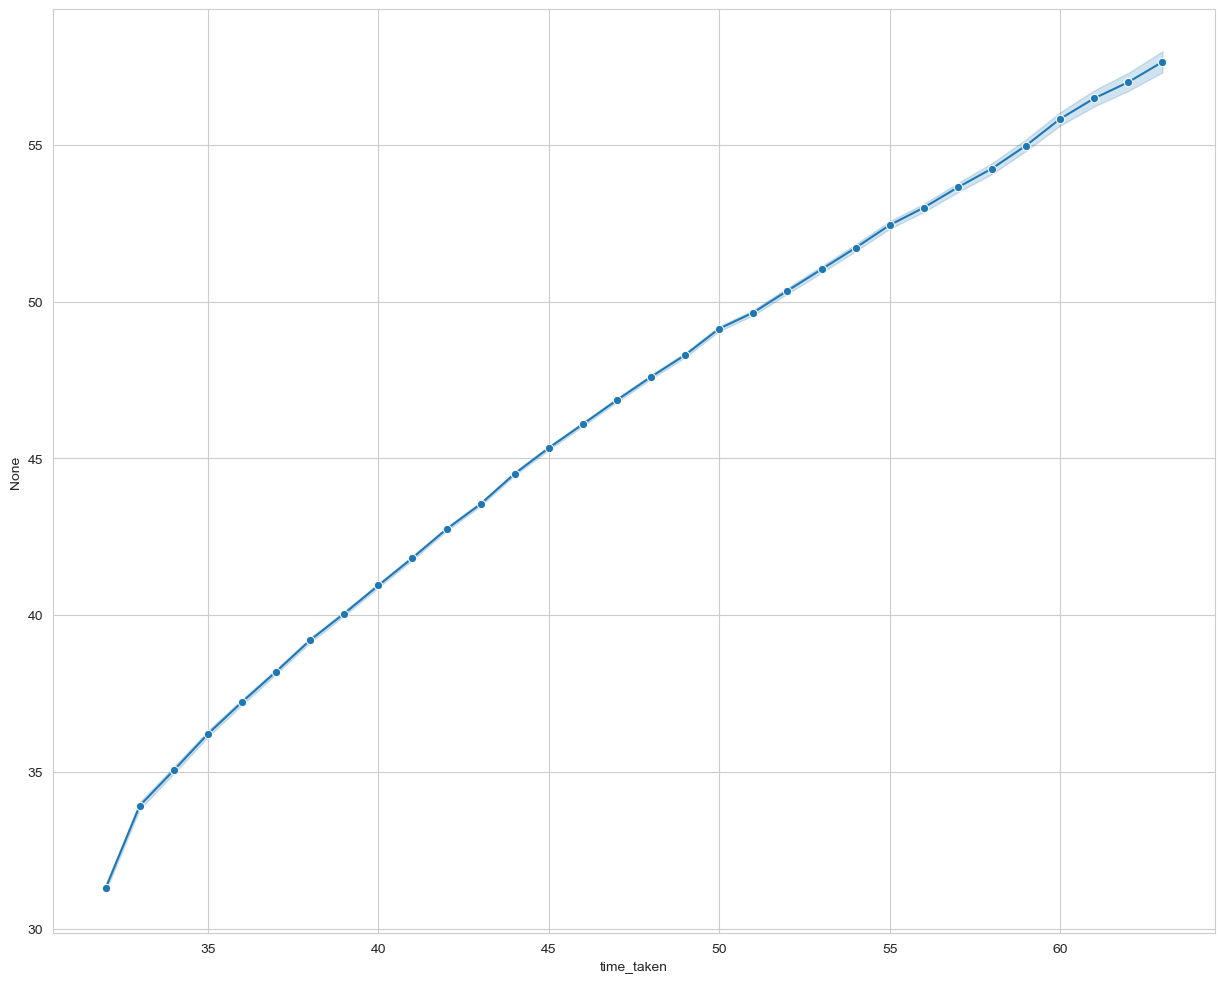

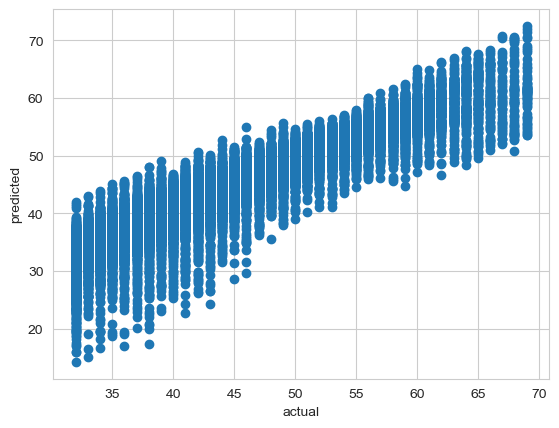

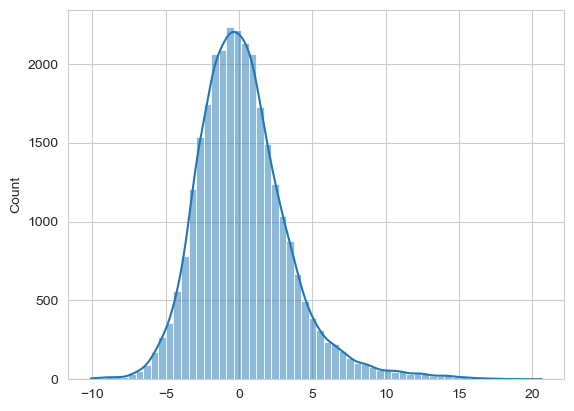

r2Score-> 0.8465270065796626
Mse-> 10.024022498921942
y_test 139667    39.0
80077     42.0
41872     48.0
151215    37.0
31509     37.0
          ... 
112022    49.0
84475     44.0
119329    33.0
3479      42.0
98870     40.0
Name: time_taken, Length: 29371, dtype: float64
y_test_pred 139667    40.126882
80077     44.522129
41872     45.590459
151215    37.670609
31509     39.115290
            ...    
112022    45.384393
84475     44.003404
119329    35.564790
3479      45.230364
98870     39.506046
Length: 29371, dtype: float64


<Figure size 800x600 with 0 Axes>

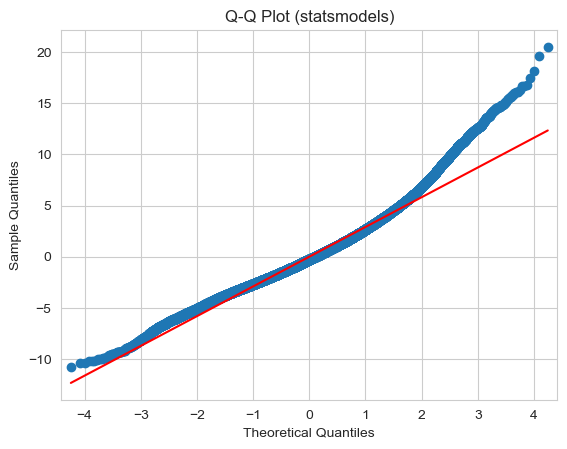

In [42]:
# Find results for evaluation metrics
import statsmodels.graphics.gofplots as gofplots
# df_test.pop('created_at')
# df_test.pop('actual_delivery_time')
# df_test.pop('day_of_week')
# df_test.pop('min_item_price')
# df_test.pop('store_primary_category')
# df_test[cols] = scaler.transform(df_test[cols])
# y_test = df_test.pop('delivery_time')
test_cols = X_train.columns
df_test[cols] = scaler.transform(df_test[cols])
print(df_test[cols].head())
print(df_test.describe())
X_test = df_test[test_cols].copy()
y_test = df_test['time_taken'].copy()
# X_test.pop('created_at')
# X_test.pop('actual_delivery_time')
# X_test = X_test.drop(['total_onshift_dashers','subtotal','total_busy_dashers','total_items','total_outstanding_orders', 'market_id'], axis = 1)
X_test_lm = sm.add_constant(X_test)
y_test_pred = lr2.predict(X_test_lm)

fig = plt.subplots(figsize = (15, 12))
sns.lineplot(x = y_train, y = y_train_pred,  marker = 'o')
plt.show()

plt.scatter(y_test, y_test_pred)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()

sns.histplot(y_test - y_test_pred, bins = 60, kde = True)
plt.show()

r2_pred = r2_score(y_test, y_test_pred)
print('r2Score->', r2_pred)
mse_pred = mean_squared_error(y_test, y_test_pred)
print('Mse->', mse_pred)

print('y_test', y_test)
print('y_test_pred', y_test_pred)

residuals = lr2.resid
plt.figure(figsize=(8, 6))
fig = gofplots.qqplot(residuals, line='s') # 's' for standardized line
plt.title(f"Q-Q Plot (statsmodels)")
plt.show()





Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

(12,)
[('market_id', True, 1), ('order_protocol', True, 1), ('total_items', True, 1), ('subtotal', True, 1), ('num_distinct_items', True, 1), ('max_item_price', True, 1), ('total_onshift_dashers', True, 1), ('total_busy_dashers', True, 1), ('total_outstanding_orders', True, 1), ('distance', True, 1), ('hour', True, 1), ('isWeekend', True, 1)]
                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 4.618e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        11:15:58   Log-Likelihood:            -2.2173e+05
No. Observations:               91628   AIC:                         4.435e+05
Df Residuals:                   91615   BIC:                         4.436e+05
Df Model:              

<Figure size 800x600 with 0 Axes>

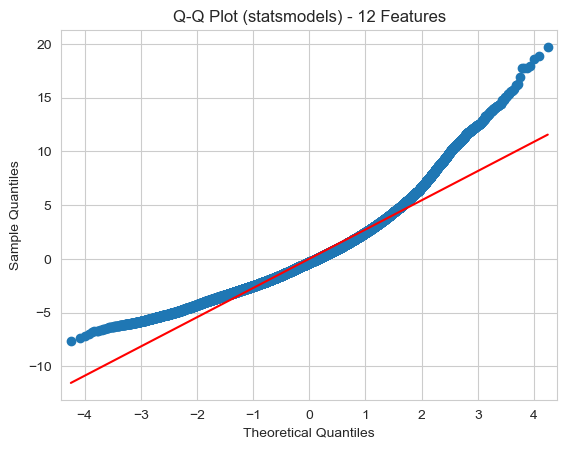

[('market_id', True, 1), ('order_protocol', True, 1), ('total_items', True, 1), ('subtotal', True, 1), ('num_distinct_items', True, 1), ('max_item_price', True, 1), ('total_onshift_dashers', True, 1), ('total_busy_dashers', True, 1), ('total_outstanding_orders', True, 1), ('distance', True, 1), ('hour', False, 2), ('isWeekend', True, 1)]
                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                 3.195e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        11:16:00   Log-Likelihood:            -2.3898e+05
No. Observations:               91628   AIC:                         4.780e+05
Df Residuals:                   91616   BIC:                         4.781e+05
Df Model:                   

<Figure size 800x600 with 0 Axes>

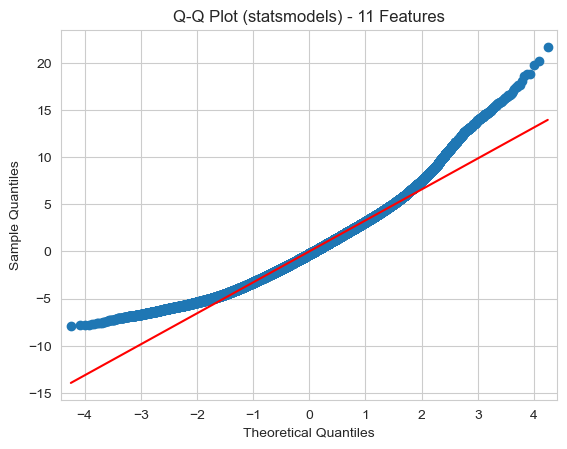

[('market_id', True, 1), ('order_protocol', True, 1), ('total_items', False, 2), ('subtotal', True, 1), ('num_distinct_items', True, 1), ('max_item_price', True, 1), ('total_onshift_dashers', True, 1), ('total_busy_dashers', True, 1), ('total_outstanding_orders', True, 1), ('distance', True, 1), ('hour', False, 3), ('isWeekend', True, 1)]
                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                 3.514e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        11:16:02   Log-Likelihood:            -2.3899e+05
No. Observations:               91628   AIC:                         4.780e+05
Df Residuals:                   91617   BIC:                         4.781e+05
Df Model:                  

<Figure size 800x600 with 0 Axes>

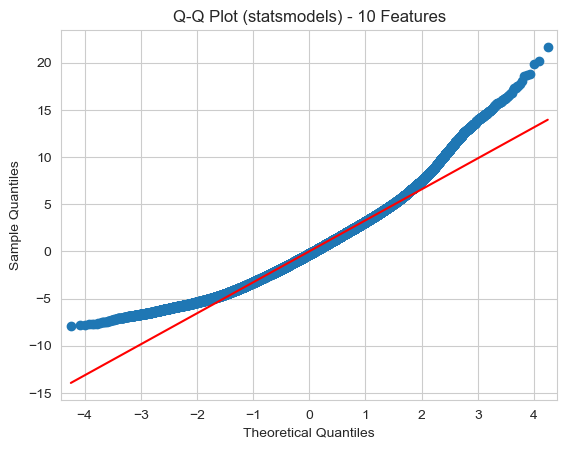

[('market_id', True, 1), ('order_protocol', True, 1), ('total_items', False, 3), ('subtotal', True, 1), ('num_distinct_items', False, 2), ('max_item_price', True, 1), ('total_onshift_dashers', True, 1), ('total_busy_dashers', True, 1), ('total_outstanding_orders', True, 1), ('distance', True, 1), ('hour', False, 4), ('isWeekend', True, 1)]
                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                 3.848e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        11:16:04   Log-Likelihood:            -2.3952e+05
No. Observations:               91628   AIC:                         4.791e+05
Df Residuals:                   91618   BIC:                         4.791e+05
Df Model:                 

<Figure size 800x600 with 0 Axes>

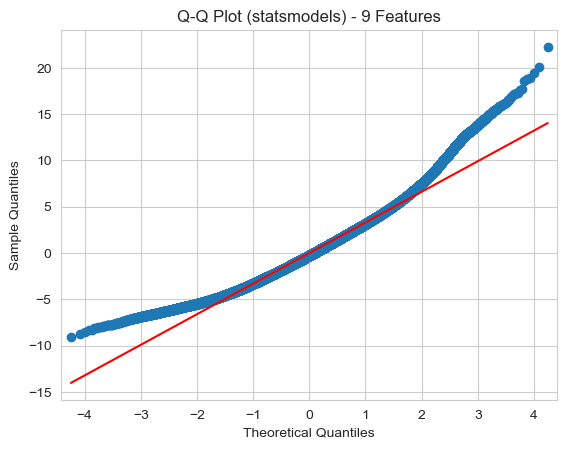

[('market_id', False, 2), ('order_protocol', True, 1), ('total_items', False, 4), ('subtotal', True, 1), ('num_distinct_items', False, 3), ('max_item_price', True, 1), ('total_onshift_dashers', True, 1), ('total_busy_dashers', True, 1), ('total_outstanding_orders', True, 1), ('distance', True, 1), ('hour', False, 5), ('isWeekend', True, 1)]
                            OLS Regression Results                            
Dep. Variable:             time_taken   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                 4.062e+04
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        11:16:05   Log-Likelihood:            -2.4182e+05
No. Observations:               91628   AIC:                         4.836e+05
Df Residuals:                   91619   BIC:                         4.837e+05
Df Model:                

<Figure size 800x600 with 0 Axes>

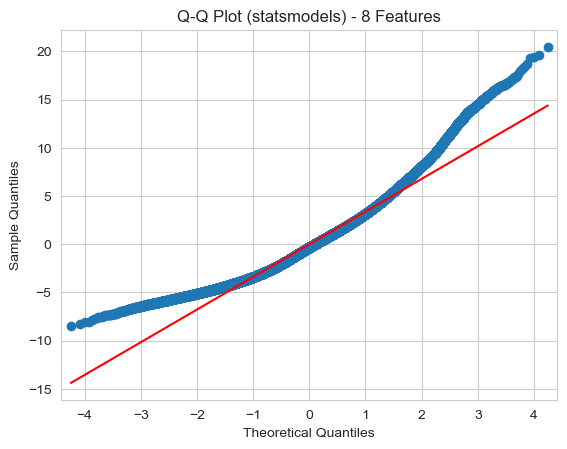

In [43]:
# Loop through the number of features and test the model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
X_train = df_train.copy()
y_train = X_train.pop('time_taken')

colums = X_train.columns
print(colums.shape)
lm = LinearRegression()
for i in range(colums.shape[0], 7 , -1):
    
    lm.fit(X_train, y_train)
    rfe = RFE(lm, n_features_to_select= i)             # running RFE
    rfe = rfe.fit(X_train, y_train)
    col_rfe = list(X_train.columns)
    print(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
    col = X_train.columns[rfe.support_]
    X_train_rfe = X_train[col]
    # print(X_train_rfe)
    X_train_rfe = sm.add_constant(X_train_rfe)
    lr_rfe = sm.OLS(y_train,X_train_rfe).fit()
    print(lr_rfe.summary())
    l = list([])
    vif = pd.DataFrame()
    vif['features'] = X_train_rfe.columns
    for j in range(X_train_rfe.shape[1]):
        l.append(variance_inflation_factor(X_train_rfe.values, j))
    vif['vif'] = l
    vif['vif'] = round(vif['vif'], 2)
    vif = vif.sort_values(by='vif', ascending=False)
    print('VIF for LR->', vif)
    residuals = lr_rfe.resid
    plt.figure(figsize=(8, 6))
    fig = gofplots.qqplot(residuals, line='s') # 's' for standardized line
    plt.title(f"Q-Q Plot (statsmodels) - {i} Features")
    plt.show()
    # print(X_train_rfe)

In [44]:
# Build the final model with selected number of features



y_train_rfe_pred = lr_rfe.predict(X_train_rfe)
print(y_train_rfe_pred)
r2_score_train = r2_score(y_train, y_train_rfe_pred)
print('r2_score_train', r2_score_train)



X_test = df_test.copy()
y_test = X_test.pop('time_taken')



X_test_rfe = X_test[col]
X_test_rfe = sm.add_constant(X_test_rfe)
             # running RFE
y_test_rfe = lr_rfe.predict(X_test_rfe)
r2_score_test_pred = r2_score(y_test, y_test_rfe)
print('r2_score_test_pred', r2_score_test_pred)

42111     34.740438
80691     42.568818
170910    39.295654
64999     47.007461
153278    43.872569
            ...    
144962    47.410460
20533     43.125700
145332    47.705504
82270     40.301983
56088     48.023155
Length: 91628, dtype: float64
r2_score_train 0.7800536906845799
r2_score_test_pred 0.8030080411049222


#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

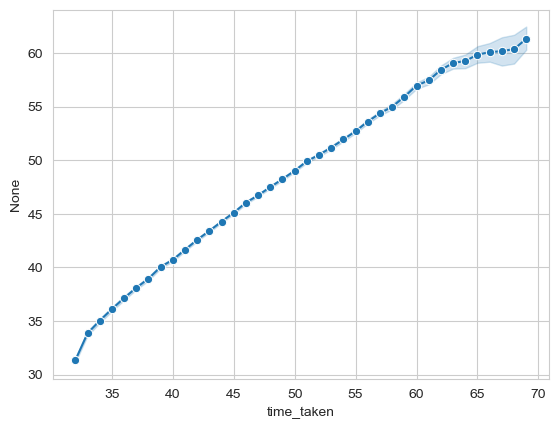

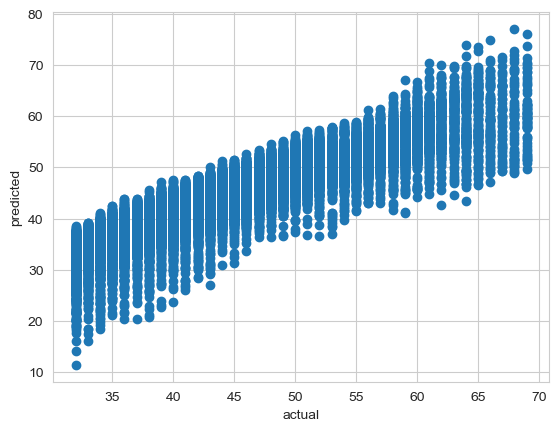

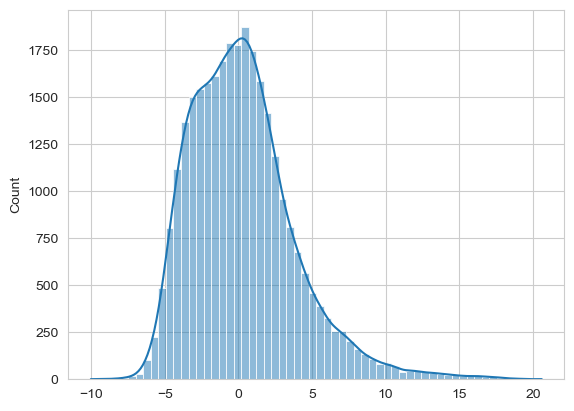

<Figure size 800x600 with 0 Axes>

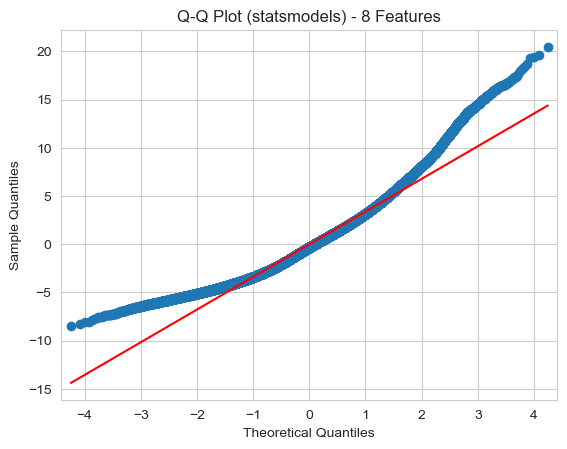

In [45]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
import statsmodels.graphics.gofplots as gofplots
sns.lineplot(x = y_test, y = y_test_pred, marker = 'o')
plt.show()


plt.scatter(y_test, y_test_rfe)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()

sns.histplot(y_test - y_test_rfe, bins = 60, kde = True)
plt.show()


residuals = lr_rfe.resid
plt.figure(figsize=(8, 6))
fig = gofplots.qqplot(residuals, line='s') # 's' for standardized line
plt.title(f"Q-Q Plot (statsmodels) - {i} Features")
plt.show()


[Your inferences here:]
So, residual analysis gives us the gap or the errors in the predicted vs the actual values.


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [46]:
# Compare the scaled vs unscaled features used in the final model
print('For Manual Linear Regression')
print(lr2.params)
scaled_coeffs = lr2.params.to_dict()
for feature, coeff in scaled_coeffs.items():
    if coeff < 0 and feature in cols:
        print('So, for Scaled Manual Linear Regression a unit increase in the feature', ' ', feature, ' would lead to ', coeff, ' ', 'decrease in time_taken or delivery time','\n')
    elif coeff < 0 and feature not in cols:
        print('So, for Scaled Manual Linear Regression a unit increase in unscaled feature', ' ', feature, ' would lead to ', coeff, ' ', 'decrease in time_taken or delivery time','\n')
    elif coeff > 0 and feature not in cols:
        print('So, for Scaled Manual Linear Regression a unit increase in unscaled feature', ' ', feature, ' would lead to ', coeff, ' ', 'increase in time_taken or delivery time', '\n')
    else:
        print('So, for Scaled Manual Linear Regression a unit increase in the feature', ' ', feature, ' would lead to ', coeff, ' ', 'increase in time_taken or delivery time', '\n')

print('For LR using RFE')
scaled_coeffs_rfe = lr_rfe.params.to_dict()
for feature, coeff in scaled_coeffs_rfe.items():
    if coeff < 0 and feature in cols:
        print('So, for Scaled Linear Regression using RFE a unit increase in the feature', ' ', feature, ' would lead to ', coeff, ' ', 'decrease in time_taken or delivery time','\n')
    elif coeff < 0 and feature not in cols:
        print('So, for Scaled Linear Regression using RFE a unit increase in unscaled feature', ' ', feature, ' would lead to ', coeff, ' ', 'decrease in time_taken or delivery time','\n')
    elif coeff > 0 and feature not in cols:
        print('So, for Scaled Linear Regression using RFE a unit increase in unscaled feature', ' ', feature, ' would lead to ', coeff, ' ', 'increase in time_taken or delivery time', '\n')
    else:
        print('So, for Scaled Linear Regression using RFE a unit increase in the feature', ' ', feature, ' would lead to ', coeff, ' ', 'increase in time_taken or delivery time', '\n')


For Manual Linear Regression
const                       36.878229
market_id                   -0.485382
order_protocol              -0.664665
total_items                 -0.423961
subtotal                     6.006773
num_distinct_items           0.558342
max_item_price               1.044626
total_onshift_dashers      -50.847986
total_outstanding_orders    45.062778
distance                    21.697592
hour                        -0.226959
isWeekend                    1.313712
dtype: float64
So, for Scaled Manual Linear Regression a unit increase in unscaled feature   const  would lead to  36.87822865942128   increase in time_taken or delivery time 

So, for Scaled Manual Linear Regression a unit increase in unscaled feature   market_id  would lead to  -0.48538217081287316   decrease in time_taken or delivery time 

So, for Scaled Manual Linear Regression a unit increase in unscaled feature   order_protocol  would lead to  -0.6646653887649908   decrease in time_taken or delivery tim

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [47]:
# Analyze the effect of a unit change in a feature, say 'total_items'
for feature, coeff in scaled_coeffs.items():
    if feature == 'total_items':
        print('For a unit increase in feature ', feature, 'it would lead to ', coeff , 'change in time_taken')


For a unit increase in feature  total_items it would lead to  -0.423961348706551 change in time_taken


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are categorical variables in the data namely store_primary_category, market_id, created_at, actual_delivery_time, day_of week, hour, isWeekend, order_protocol, num_distinct_items.
Generally they tend to have negative coefficients meaning that per unit increase of the said variable tends to decrease the delivery time and vice versa.isWeekend, num_distinct_items have positive coefficients meaning that per unit increase increases the delivery time.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>It splits the original data frame meaning that if we consider whole df into 1 then 0.2 will be the ratio of the split while 0.8 will be training data set.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Distance has the highest correlation of 0.46 with the target variable time_taken



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>I made functions to calculate IQR and applied the formula of q1 - 1.5 * Iqr and q3 + 1.5 * IQR to detect the outliers and handled them with median values. Also removed negative values if any.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>total_busy_dashers, total_outstanding_orders, distance are the top 3 features affecting delivery time for my final manual LR model. While, total_onshift_dashers,
total_outstanding_orders and 
distance are the top features effecting delivery time for LR model using RFE



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear Regression technique or algorithm finds the best fit or line between the dependent and the independent variables. It can be simple Linear Regression or One dependent and one independent variable or multiplt LR meaning one target(dependent) variable and multiple independent variable.We use minimization of squared errors to find the best fit between them.Generally it is assumed that the error terms are normally distributed with zero mean and constant variance and that they are independent of each other. Also Multicollinearity (interdependence of independent variables among themselves) is assumed to be avoided. 




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>In simple Linear Regression there are two variables whereby one id target or dependent variable and the other is independent variable. It is like the equation of a straight line y = B0 + B1*x
where y is the target variable and B0 is the intercept and B1 is the coefficient of the independent variable 'x'. We have to find the best straight line for y.While multiple Linear Regression is when there is one dependent variable and multiple independent variables.y = B0 + B1x1 + B2x2.....Bnxn.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>In Linear Regression we minimize the cost function meaning we minimize the sum of the squared errors to find the best fit line for the given problem. 1 - RSS/TSS is to be minimized, meaning we minimize the Residual sum of squares and the Total sum of squares or (TSS - RSS) / TSS or MSE / TSS meaning we minimize the mean sum of squared errors.
> 
> The most common cost function is the Mean Square Error or MSE = sum(y^ - y)^2 / n
> 
> or beta = X^T*y*(X^T * X)^-1
> 




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>In overfitting we tend to minimize the error to so much extent that it actually handles all the data points whereby it performs well on the training set but fails miserably on the test or unseen data while in underfitting we ignore most of the data and the models predictions are far off.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
As seen in the assignment above we can use residuals or the error terms to diagnose wether model has performed well or not by plotting Actual vs Predicted scattered plots or histograms or even Q-Q plots. These plots help us diagnosing the problems with the model that we use for predictions.